# UTK Face Classification

The project uses the human face images' dataset uploaded from the Kaggle website (https://www.kaggle.com/datasets/jangedoo/utkface-news). UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 104 years old). The dataset consists of over 20000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

In total, there are 57596 image files in five folders: 'part1', 'part2', 'part3', 'UTKFace' and 'crop_part1'. Some of these images are duplicates. Also, the folders contain images of diferent size and resolution representing the the same persons.Also, the dataset provides the corresponding landmarks (68 points). Images are labelled by age, gender, and ethnicity. the label info is embedded in the names of image files, formated like [age]_[gender]_[race]_[date&time].jpg

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

The purpose of the project is to apply transfer learning for training multitask classifiers which would be able to corectly predict age and gender for the face images - that is, to provide gender and age labels to images of faces of various persons. 

The project consists of two parts: 1) the exploratory analysis of the dataset of face images and 2) building, training, fine-tuning and evaluating classifiers able to predict age and gender of face images.

### Importing libraries

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib and seaborn will be used for data visualization. THE PIL library will be used for image processing. os, glob and shutil libraries will be used for working with files in local folders. Re library will be used for to read information from image names. Lime and skimage libraries will be used for interpretability. Various modules of the torch library as well as pytorch-lightning will be used for data loading, importing pretrained models, training, summarizing and fine-tuning. Sklearn metrics will be used for presenting confusion matrix and classification report. 

The modelling was performed on the Mac computer with the M2 processor (10 GPU cores), thus the pytorch-lighhtning library rather than the fastai library was chosen for the modelling purposes. It was observed that there are difficulties in assigning Mac GPU's while using the fastai library (while the library works well with cuda). 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

import torchvision
import torch.optim as optim
import torch.utils.data as data, torchvision as tv
import torchvision.datasets as datasets
import torchvision.transforms as transforms


from torchvision.io import read_image
from torchvision import models
from torchvision.models import resnet50, resnet152, resnet18, ResNet50_Weights
from torchvision.datasets import ImageFolder
from torchmetrics.classification import Accuracy
from torchvision.transforms import ToTensor, Lambda
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.data import (
    TensorDataset,
    DataLoader,
    Dataset,
    random_split,
    WeightedRandomSampler,
)
from torchsummary import summary

import pytorch_lightning as pl

import os
import re
import random
import pickle
import glob
import shutil

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import time
from collections import Counter
from scipy import stats

from lime import lime_image

import requests
from PIL import Image
from PIL import ImageFile
from io import BytesIO

from skimage import io, transform
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.segmentation import mark_boundaries

from typing import Any, List, Tuple, Union, Dict
import itertools

import warnings
from utkface_dataset import UTKFaceDataset, UTKFaceMergedDataset
warnings.filterwarnings("ignore")


In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Importing data

In order to import the image dataset and to observe and preprocess random images from the dataset, the pytorch lightning class 'UTKDFaceDataset' is created. To read images from the local folders the torchvision.datasets attribute ImageFolder was applied. 


In [3]:
data_dir = "/Users/user/PycharmProjects/AdvancedDeepLearning/images"

<IPython.core.display.Javascript object>

The class metod setup() initiated the dataset with the class.

In [4]:
dataset = UTKFaceDataset(data_dir)
dataset.setup()


<IPython.core.display.Javascript object>

## 1. Exploratory analysis

The exploratory analysis of the face image dataset includes examination of width, height, numbers of pixels, modes of channels of images. The dataframe with the data on various parameters of images is created by looping over images in the folders. 

Random images from five folders are presented bellow with the methos 'show_random_images' of the class.

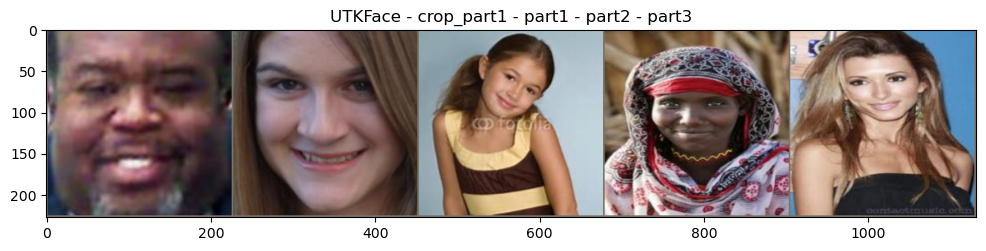

<IPython.core.display.Javascript object>

In [5]:
dataset.show_random_images(num_images=5)

In [6]:
class_folders = os.listdir(data_dir)
class_folders.remove(".DS_Store")
num_images_per_class = 1
images_dict = {}
images_dict["img_path"] = []
images_dict["img_height"] = []
images_dict["img_width"] = []
images_dict["img_num_pixels"] = []
images_dict["img_num_channels"] = []
# fig, axes = plt.subplots(1, 5, figsize=(8, 2))

for i, class_name in enumerate(class_folders):
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(".jpg")]
    for image in images:
        img = Image.open(class_path + "/" + image)
        width, height = img.size
        img_num_pixels = width * height
        num_channels = img.mode
        images_dict["img_path"].append(image)
        images_dict["img_height"].append(height)
        images_dict["img_width"].append(width)
        images_dict["img_num_pixels"].append(img_num_pixels)
        images_dict["img_num_channels"].append(num_channels)


<IPython.core.display.Javascript object>

The data on size and numbers of pixes are presented in the dataframe (see bellow).

In [7]:
images_df = pd.DataFrame(images_dict)
images_df.head()

img_path  img_height  img_width  img_num_pixels  \
0  27_0_1_20170120133818199.jpg         451        452          203852   
1  24_0_3_20170119165522935.jpg         413        490          202370   
2   8_1_0_20170117154607954.jpg         451        276          124476   
3  85_1_0_20170120222635457.jpg         293        694          203342   
4  26_1_0_20170119192908266.jpg         343        590          202370   

  img_num_channels  
0              RGB  
1              RGB  
2              RGB  
3              RGB  
4              RGB

<IPython.core.display.Javascript object>

It can be observed that the size of image varies a lot - the size of smallest images is the height 69 and the width 87 while the largest images have tyhe height 8739 and the width 8198.

In [8]:
images_df.describe()

img_height     img_width  img_num_pixels
count  57596.000000  57596.000000    5.759600e+04
mean     393.442270    383.190881    2.486376e+05
std      337.470555    335.323027    8.092265e+05
min       69.000000     87.000000    6.003000e+03
25%      200.000000    200.000000    4.000000e+04
50%      200.000000    200.000000    4.000000e+04
75%      519.000000    470.000000    2.037000e+05
max     8739.000000   8198.000000    6.821663e+07

<IPython.core.display.Javascript object>

The Shapiro test is used to test if height, width and number of pixels variables are normally distributed. As it seen from the results of the Shapiro Wilk test, widths, hights, and numbers of pixels are not normally distributed (p values are lower than 0.05).

In [9]:
for column, values in images_df.iloc[:, 1:4].items():
    stat, p = stats.shapiro(values)
    print(f"{column}")
    print(f"Shapiro Wilk test statistics: {stat}")
    print(f"p-value: {p}")
    if p > 0.05:
        print(
            "The data appears to be normally distributed (fail to reject null hypothesis)."
        )
    else:
        print(
            "The data does not appear to be normally distributed (reject null hypothesis)."
        )
    print("")

img_height
Shapiro Wilk test statistics: 0.6269350647926331
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).

img_width
Shapiro Wilk test statistics: 0.602388322353363
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).

img_num_pixels
Shapiro Wilk test statistics: 0.18735140562057495
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).



<IPython.core.display.Javascript object>

The plot shows that the vast majority of images has the size (height and width) parameters lower than 1000.

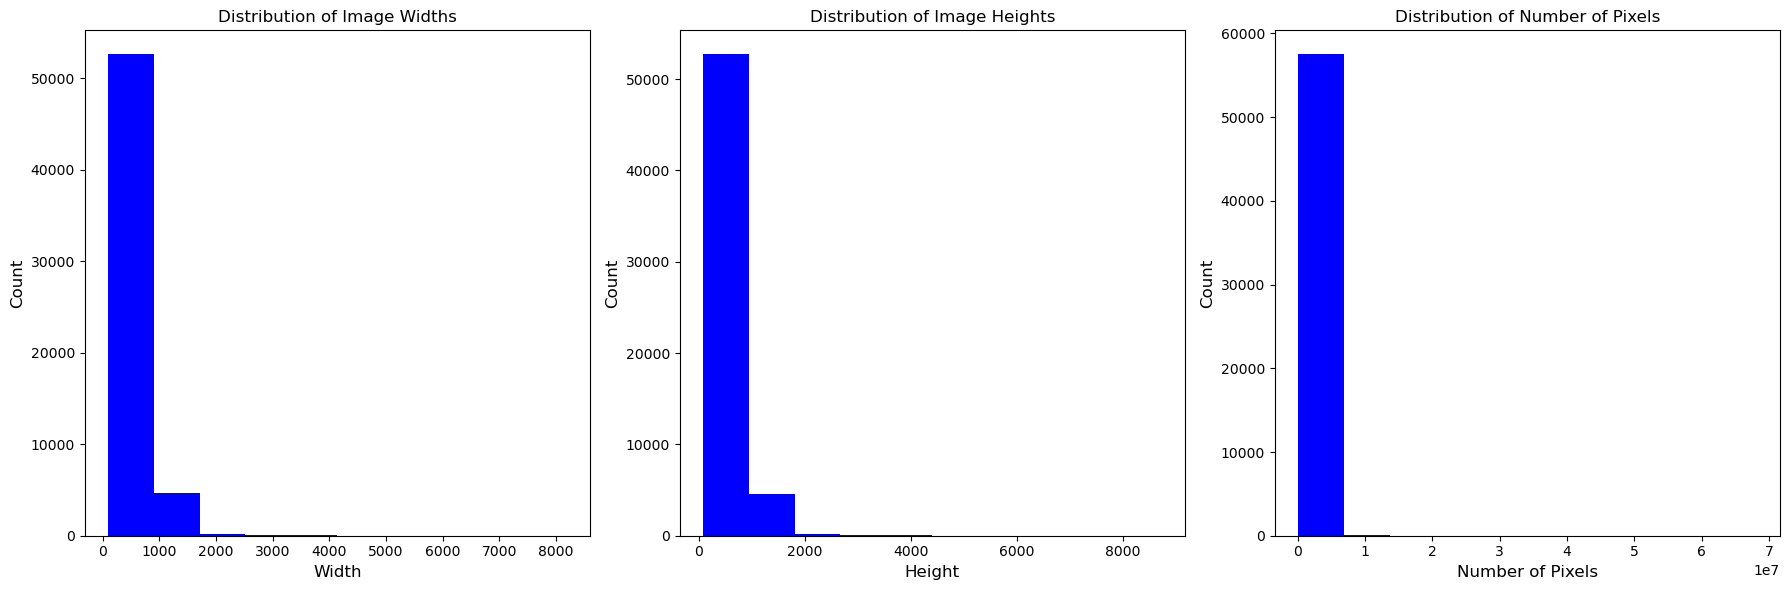

<IPython.core.display.Javascript object>

In [10]:
images_df['num_pixels'] = images_df['img_width'] * images_df['img_height']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

images_df['img_width'].plot(kind='hist', ax=axes[0], color='blue')
axes[0].set_title('Distribution of Image Widths', fontsize=12)
axes[0].set_xlabel('Width', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

images_df['img_height'].plot(kind='hist', ax=axes[1], color='blue')
axes[1].set_title('Distribution of Image Heights', fontsize=12)
axes[1].set_xlabel('Height', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

images_df['num_pixels'].plot(kind='hist', ax=axes[2], color='blue')
axes[2].set_title('Distribution of Number of Pixels', fontsize=12)
axes[2].set_xlabel('Number of Pixels', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()


For the deeper examination of distributions of widths and heights of images the widths and heights were grouped by intervals and trasformed into categorical variables by the function 'categorize_num_variable()". The bar plot bellow shows that the highest numbers of images are of height and width lower than 200. Images of sizes in the intervals 200-400, 400-600, and 600-800 are distributed almost equally while larger images are rarer. 

In [11]:
def categorize_num_variable(variable: int, intervals: list) -> int:
    """
    Categorizes the given numerical variable into a specific interval based on the given intervals.

    Args:
        variable (int): The numerical variable to be categorized.
        intervals (list): A list of intervals (represented as a list of two integers)
        to categorize the size parameter into.

    Returns:
        int: The index of the interval that the numerical variable falls into.
        If it does not fall into any interval, returns -1.
    """
    for i, interval in enumerate(intervals):
        if interval[0] <= variable <= interval[1]:
            return i
    return -1

<IPython.core.display.Javascript object>

In [12]:
size_intervals = [
    (0, 200),
    (201, 400),
    (401, 600),
    (601, 800),
    (801, 1000),
    (1001, 2000),
    (2001, 3000),
    (3001, 10000),
]

<IPython.core.display.Javascript object>

In [13]:
categorized_widths = [
    categorize_num_variable(size, size_intervals) for size in images_df["img_width"]
]
categorized_heights = [
    categorize_num_variable(size, size_intervals) for size in images_df["img_height"]
]

<IPython.core.display.Javascript object>

In [14]:
size_df = pd.DataFrame(
    {"width_size": categorized_widths, "height_size": categorized_heights}
)

<IPython.core.display.Javascript object>

In [15]:
width_number = pd.DataFrame(size_df["width_size"].value_counts())
height_number = pd.DataFrame(size_df["height_size"].value_counts())

<IPython.core.display.Javascript object>

<Figure size 600x400 with 0 Axes>

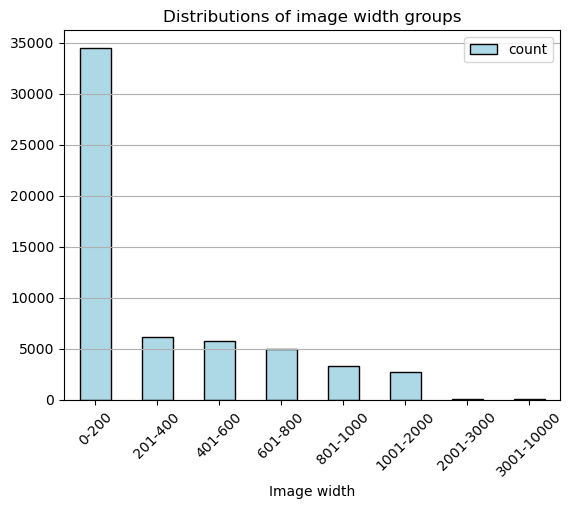

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(6, 4))
width_number.plot(kind="bar", color="lightblue", edgecolor="black")
plt.title("Distributions of image width groups")
plt.xlabel("Image width")
plt.ylabel("")
plt.xticks(
    ticks=range(len(size_intervals)),
    labels=[f"{interval[0]}-{interval[1]}" for interval in size_intervals],
    rotation=45,
)
# plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()

<Figure size 600x400 with 0 Axes>

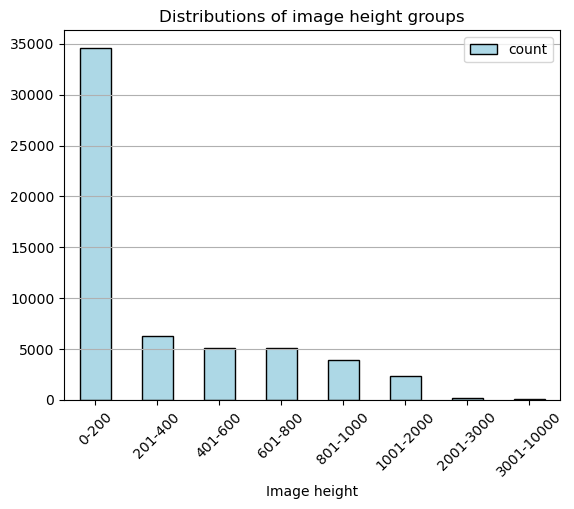

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(6, 4))
height_number.plot(kind="bar", color="lightblue", edgecolor="black")
plt.title("Distributions of image height groups")
plt.xlabel("Image height")
plt.ylabel("")
plt.xticks(
    ticks=range(len(size_intervals)),
    labels=[f"{interval[0]}-{interval[1]}" for interval in size_intervals],
    rotation=45,
)
# plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()

The majority of images are colourful (RGB channel), only 11 images are greyscale and 9 images have RGBA color model (A represents transparency).

In [18]:
images_df["img_num_channels"].value_counts()

img_num_channels
RGB     57576
L          11
RGBA        9
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In order to observe the transformation effects on images, the transformation pipeline was constructed and applied to randomly selected images (see the augmented image bellow).

In [19]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

<IPython.core.display.Javascript object>

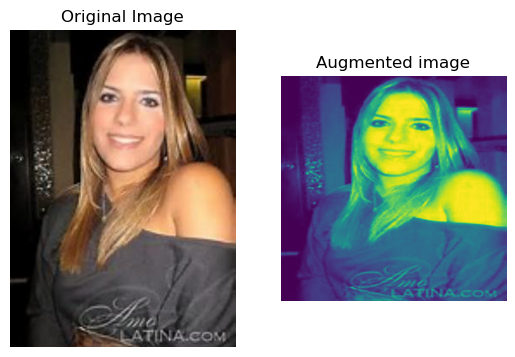

<IPython.core.display.Javascript object>

In [20]:
random_image = random.choice(images)
example_image = Image.open(class_path + "/" + random_image)

augmented_image1 = transform(example_image).numpy()[0]

fig, axs = plt.subplots(1, 2)

axs[0].imshow(example_image)
axs[0].set_axis_off()
axs[0].set_title("Original Image")

axs[1].imshow(augmented_image1)
axs[1].set_axis_off()
axs[1].set_title("Augmented image")

plt.show()

Also, the dataset includes a text file with landmark information and the matlab file to process this information. In order, to understand what inform this file includes the code of the matlab file was transformed into the python code with the help of the ChatGPT-4 (the promt which was used: "transform this matlab code to python.") The output of the code and the plots of landmarks for 5 randomly selected images are presented bellow.

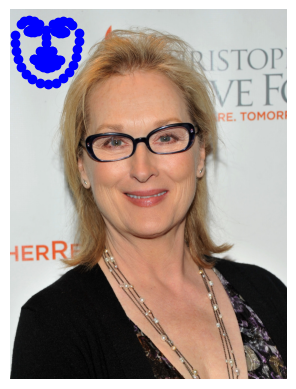

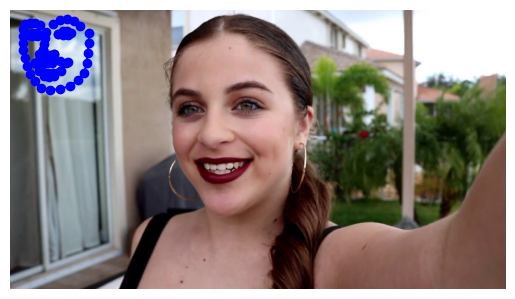

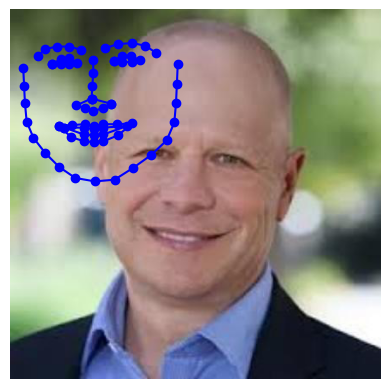

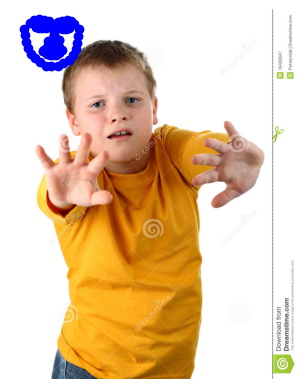

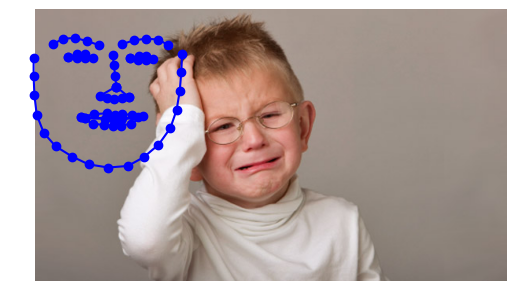

<IPython.core.display.Javascript object>

In [21]:
imgPath = './images/part1'
files = glob.glob(os.path.join(imgPath, '*.jpg'))

landmark_list = []
with open('./landmark_list.txt', 'r') as file:
    for line in file:
        parts = line.split()
        filename = parts[0]
        landmarks = [float(x) for x in parts[1:]]
        landmark_list.append({
            'name': filename,
            'landmark': [landmarks[i:i+2] for i in range(0, len(landmarks), 2)]
        })

if len(files) != len(landmark_list):
    print('Warning: Mismatching of landmark list and image number!')


num_images_to_display = 5

random_landmark_list = random.sample(landmark_list, num_images_to_display)


for item in random_landmark_list:
    file = item['name']
    try:
        img = Image.open(os.path.join(imgPath, file))
        plt.imshow(img)
        plt.axis('off')

        landmark = item['landmark']
        plt.plot(*zip(*landmark[0:17]), marker='o', color='b', linestyle='-')
        plt.plot(*zip(*landmark[27:31]), marker='o', color='b', linestyle='-')
        plt.plot(*zip(*landmark[17:22]), marker='o', color='b', linestyle='-')
        plt.plot(*zip(*landmark[22:27]), marker='o', color='b', linestyle='-')
        plt.plot(*zip(*landmark[30:36]), marker='o', color='b', linestyle='-')
        plt.plot([landmark[30][0], landmark[35][0]], [landmark[30][1], landmark[35][1]], marker='o', color='b', linestyle='-')
        plt.plot(*zip(*landmark[36:42] + [landmark[36]]), marker='o', color='b', linestyle='-')
        plt.plot(*zip(*landmark[42:48] + [landmark[42]]), marker='o', color='b', linestyle='-')
        plt.plot(*zip(*landmark[48:60] + [landmark[48]]), marker='o', color='b', linestyle='-')
        plt.plot(*zip(*landmark[60:68] + [landmark[60]]), marker='o', color='b', linestyle='-')

        plt.show()
    except FileNotFoundError:
        print(f'Warning: Cannot find the file {os.path.join(imgPath, file)}')


### Extracting labels from file names and modifying incorrect file names

The next task was to extract label information from the names from names of image files. For that purpose the function 'extract_image_info' was created which uses regex pattern for data extraction, save the extracted data into a dictionary and transforms it into a pandas dataframe. Also, it checks if teh name of the image matches the required format and outputs the names of files not matching the format.

In [22]:
def extract_image_info(folder_path: str) -> pd.DataFrame:
    """
    Extracts information from image file names in the given folder and saves it into a dataframe.
    The file names are in the format 'age_gender_race_datetime.jpg', where:
    - age is an integer from 0 to 116
    - gender is either 0 (male) or 1 (female)
    - race is an integer from 0 to 4 (denoting White, Black, Asian, Indian, and Others)
    - datetime is in the format yyyymmddHHMMSSFFF

    Parameters:
    folder_path (str): Path to the folder containing the images

    Returns:
    DataFrame: A pandas DataFrame containing the extracted information
    """
    info_list = []

    pattern = r'(\d+)_(0|1)_(\d)_(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})(\d{3})\.jpg'

    for filename in os.listdir(folder_path):
        match = re.match(pattern, filename)
        if match:
            age, gender, race, year, month, day, hour, minute, second, millisecond = match.groups()
            datetime = f'{year}-{month}-{day}:{hour}:{minute}:{second}:{millisecond}'
            info = {
                'filename': filename,
                'age': int(age),
                'gender': 'male' if gender == '0' else 'female',
                'race': ['White', 'Black', 'Asian', 'Indian', 'Others'][int(race)],
                'datetime': datetime
            }
            info_list.append(info)
        else:
            print(f'the file <{filename}> does not match this format.')

    return pd.DataFrame(info_list)


<IPython.core.display.Javascript object>

The function was looped over the subfolders of directory containing images. After the execution of the initial loop, aproximatelly 10 files with incorrect name format were identified - some files with missing gender or race data, other with missing dots, etc. All names of the files were corrected manually. Missing label information was also added by opening and examining the images in the local foldel. Finally, as it can be seen from the output bellow, no incorrectly named files were left. 

In [23]:
main_folder_path = "/Users/user/PycharmProjects/AdvancedDeepLearning/images"
image_info_list = []
df_name_list = []
for folder in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder)
    if os.path.isdir(folder_path):
        print(folder)
        df = extract_image_info(folder_path)
        image_info_list.append(df)
        df_name_list.append(folder)
        df.to_csv(f"image_labels/image_info_{folder}2.csv")

part3
the file <.DS_Store> does not match this format.
crop_part1
part2
UTKFace
part1


<IPython.core.display.Javascript object>

### Analysis of image labels data

Next, the files and their labels in the folders were examined. It can be observed, that the largest folder is UTKFace with 23708 images. The smallest folder is part3 with 3252 images. 9780 files in the crop_part1 folder are croped from images in the part1 folder.

In [24]:
for df, df_name in zip(image_info_list, df_name_list):
    print(f"Folder:{df_name}")
    print(len(df))
    print("")

Folder:part3
3252

Folder:crop_part1
9780

Folder:part2
10719

Folder:UTKFace
23708

Folder:part1
10137



<IPython.core.display.Javascript object>

Values of gender and race (categorical variables) were counted, for the numerical age variable pandas function describe() was applied to get descriptive statistics of the variable (mean, etc.)

In [25]:
gender_counts_list = []
race_counts_list = []
age_describe_list = []
for df, df_name in zip(image_info_list, df_name_list):
    print(df_name)
    age_describe = df["age"].describe()
    gender_counts = pd.DataFrame(df["gender"].value_counts())
    race_counts = pd.DataFrame(df["race"].value_counts())
    print("Gender:")
    print(gender_counts)
    print("Race:")
    print(race_counts)
    print("Age:")
    print(age_describe)
    gender_counts_list.append(gender_counts)
    race_counts_list.append(race_counts)
    age_describe_list.append(age_describe)

part3
Gender:
        count
gender       
male     2255
female    997
Race:
        count
race         
Indian   1974
White     908
Black     260
Asian      73
Others     37
Age:
count    3252.000000
mean       40.556273
std        17.305679
min         1.000000
25%        26.000000
50%        35.000000
75%        53.000000
max       116.000000
Name: age, dtype: float64
crop_part1
Gender:
        count
gender       
female   5408
male     4372
Race:
        count
race         
White    5265
Asian    1553
Indian   1453
Others   1103
Black     406
Age:
count    9780.000000
mean       29.421575
std        24.777333
min         1.000000
25%         7.000000
50%        25.000000
75%        49.000000
max       110.000000
Name: age, dtype: float64
part2
Gender:
        count
gender       
male     5789
female   4930
Race:
        count
race         
White    3919
Black    3877
Asian    1810
Indian    560
Others    553
Age:
count    10719.000000
mean        34.699039
std         13.979262
min 

<IPython.core.display.Javascript object>

Percentages for the counted values were calculated and distributions of gender and race values in five folders were plotted with barplots (see bellow).

In [26]:
def transform_answers(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the answers in the given DataFrame to percentages, rounded to two decimal places.

    Parameters:
        data (pd.DataFrame): A DataFrame containing the answers to be transformed.

    Returns:
        pd.DataFrame: A DataFrame with the transformed answers in percentages.
    """
    data = (data.iloc[:, :] / data.iloc[:, :].sum() * 100).round(2)
    return data

<IPython.core.display.Javascript object>

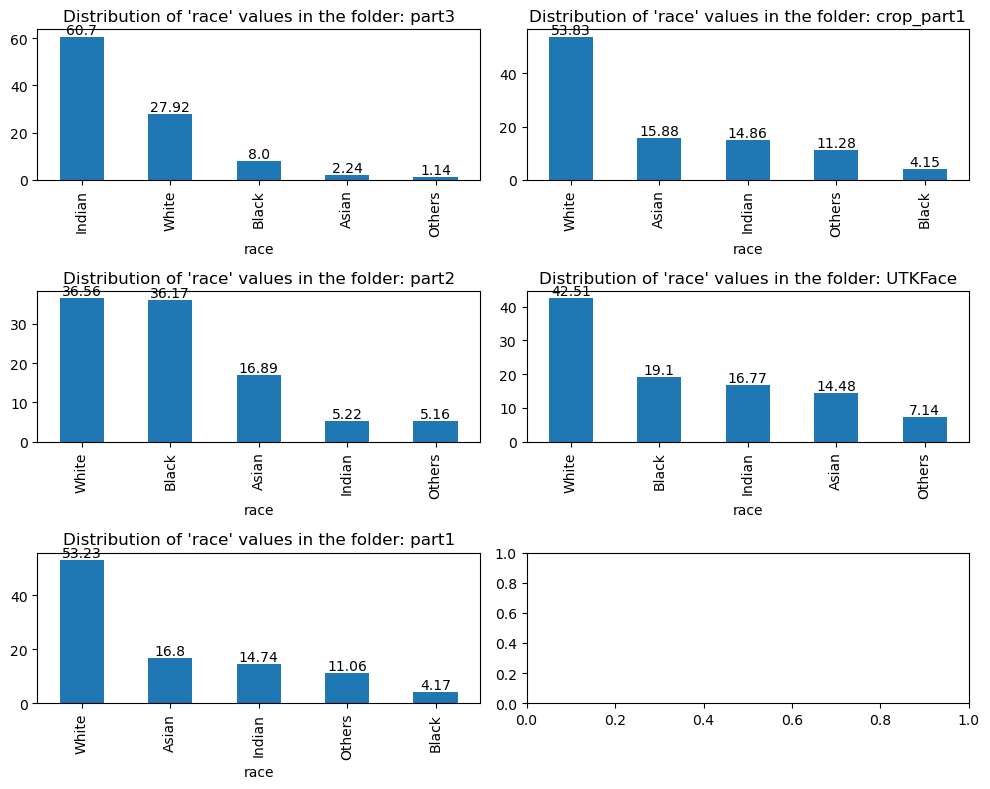

<IPython.core.display.Javascript object>

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

for i, df, df_name in zip(range(len(df_name_list)), race_counts_list, df_name_list):
    ax = axes[i // 2, i % 2]
    df = transform_answers(df)

    bars = df.plot(kind="bar", ax=ax)

    ax.set_title(f"Distribution of 'race' values in the folder: {df_name}")

    for bar in bars.patches:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height}",
            ha="center",
            va="bottom",
        )

    if ax.get_legend():
        ax.get_legend().remove()

plt.tight_layout()

plt.show()

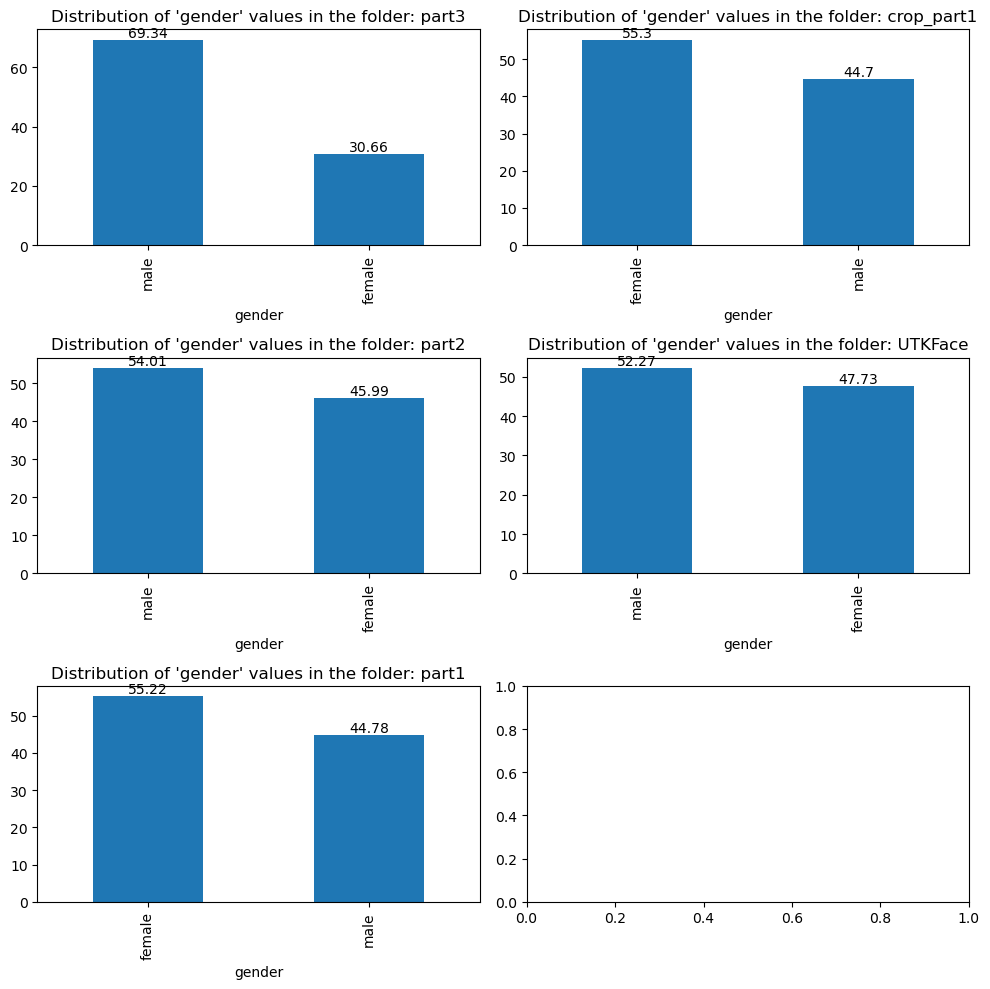

<IPython.core.display.Javascript object>

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, df, df_name in zip(range(len(df_name_list)), gender_counts_list, df_name_list):
    ax = axes[i // 2, i % 2]
    df = transform_answers(df)
    bars = df.plot(kind="bar", ax=ax)

    ax.set_title(f"Distribution of 'gender' values in the folder: {df_name}")

    for bar in bars.patches:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height}",
            ha="center",
            va="bottom",
        )
    if ax.get_legend():
        ax.get_legend().remove()

plt.tight_layout()

plt.show()

Means of the age of persons whose faces are presented in images were compared between the folders (see the barplot bellow).

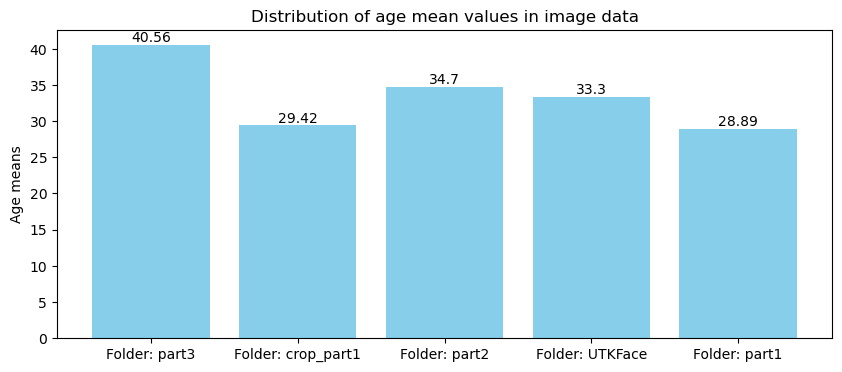

<IPython.core.display.Javascript object>

In [29]:
age_means = [s[1] for s in age_describe_list]


plt.figure(figsize=(10, 4))
bars = plt.bar(range(len(age_means)), age_means, color="skyblue")

plt.xlabel("")
plt.ylabel("Age means")
plt.title("Distribution of age mean values in image data")
plt.xticks(
    range(len(age_means)),
    [f"Folder: {df_name}" for i, df_name in zip(range(len(age_means)), df_name_list)],
)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
    )

plt.show()

### Merging folders and and dataframes of image labels

For the purposes of multitask model training the images had to be merged into a single folder and duplicates removed. The functions 'merge_folder' and 'get_folder_paths' were used for that purpose. 

In [30]:
def merge_folders(source_folders: List[str], dest_folder: str) -> None:
    """
    Merges the contents of multiple source folders into a destination folder.
    If the destination folder does not exist, it will be created.
    Duplicate files will be removed during the merge process.

    Args:
        source_folders: List of source folders to merge from.
        dest_folder: Destination folder to merge into.

    Returns:
        None
    """
    os.makedirs(dest_folder, exist_ok=True)
    counter = 0

    for folder in source_folders:
        for filename in os.listdir(folder):
            source_file = os.path.join(folder, filename)
            destination_file = os.path.join(dest_folder, filename)

            if os.path.exists(destination_file):
                counter += 1
            shutil.copy2(source_file, destination_file)

    print(f'{counter} duplicate files were removed.')


<IPython.core.display.Javascript object>

In [31]:
def get_folder_paths(directory: str) -> List[str]:
    """
    Returns a list of all the folder paths within the given directory.

    Args:
        directory (str): The path of the directory to search.

    Returns:
        List[str]: A list of folder paths within the given directory.
    """
    folder_paths: List[str] = []
    for item in os.listdir(directory):
        item_path: str = os.path.join(directory, item)
        if os.path.isdir(item_path):
            folder_paths.append(item_path)
    return folder_paths

<IPython.core.display.Javascript object>

In [32]:
folder_paths_list = get_folder_paths(main_folder_path)


<IPython.core.display.Javascript object>

In [33]:
dest_folder = '/Users/user/PycharmProjects/AdvancedDeepLearning/images_merged'
merge_folders(folder_paths_list, dest_folder)


57596 duplicate files were removed.


<IPython.core.display.Javascript object>

Images were saved into a new folder 'images_merged'. Also, the file '.DS_Store' was removed from the folder. 

In [34]:
os.remove("/Users/user/PycharmProjects/AdvancedDeepLearning/images_merged/.DS_Store")

<IPython.core.display.Javascript object>

### Examining images in the merged dataset

The function 'extract_image_info' was run on the files in the new folder in order to find out remaining incorrectly named files and to construct the dataframe from the information in the file names. 

In [35]:
folder_path_merged = "/Users/user/PycharmProjects/AdvancedDeepLearning/images_merged"
images_merged_info = extract_image_info(folder_path_merged)
images_merged_info.to_csv(f"image_labels/image_info_merged.csv")

<IPython.core.display.Javascript object>

The new folder includes 47816 image files.

In [36]:
len(images_merged_info)

47816

<IPython.core.display.Javascript object>

The labels of the files were examined by counting values of gender and race variables and getting descriptive statistics of the age variable.

In [37]:
race_counts_merged = pd.DataFrame(images_merged_info["race"].value_counts())
gender_counts_merged = pd.DataFrame(images_merged_info["gender"].value_counts())
age_mean_merged = images_merged_info["age"].describe()[1]


print(race_counts_merged)
print("")
print(gender_counts_merged)
print("")
print(f"Age:{age_mean_merged}")

        count
race         
White   20301
Black    9088
Indian   8004
Asian    7020
Others   3403

        count
gender       
male    24975
female  22841

Age:33.17393759411076


<IPython.core.display.Javascript object>

The distributions of gender and race labels as well as groups of age intervals in the image files were plotted by barplots (see bellow).

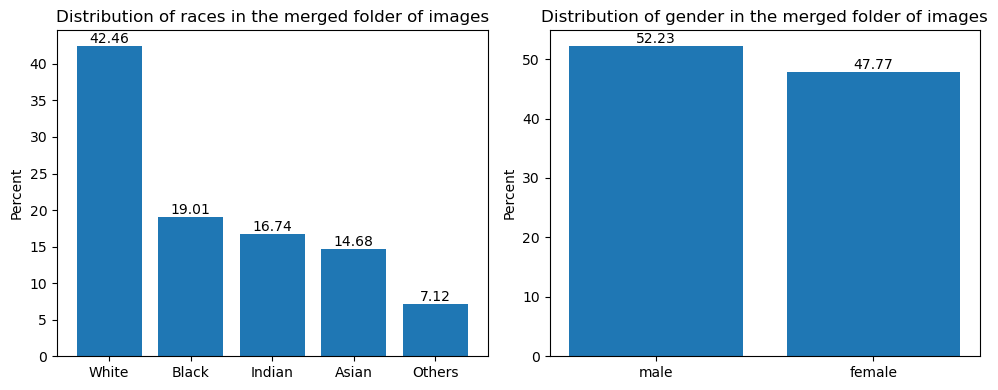

<IPython.core.display.Javascript object>

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

data1 = transform_answers(race_counts_merged)
data2 = transform_answers(gender_counts_merged)

bars1 = axes[0].bar(data1.index, data1["count"])
axes[0].set_title("Distribution of races in the merged folder of images")
axes[0].set_ylabel("Percent")


bars2 = axes[1].bar(data2.index, data2["count"])
axes[1].set_title("Distribution of gender in the merged folder of images")
axes[1].set_ylabel("Percent")


for bar in bars1:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
    )

for bar in bars2:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
    )

if axes[0].get_legend():
    axes[0].get_legend().remove()
if axes[1].get_legend():
    axes[1].get_legend().remove()

plt.tight_layout()
plt.show()

In [39]:
age_intervals = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), 
                 (71, 80), (81, 90), (91, 100), (101,120)]


<IPython.core.display.Javascript object>

In [40]:
categorized_ages = [
    categorize_num_variable(age, age_intervals) for age in images_merged_info["age"]
]

<IPython.core.display.Javascript object>

In [41]:
age_df = pd.DataFrame(
    {
        "age_groups": categorized_ages,
    }
)
age_group_percent = (age_df["age_groups"].value_counts(normalize=True) * 100).round(2)

<IPython.core.display.Javascript object>

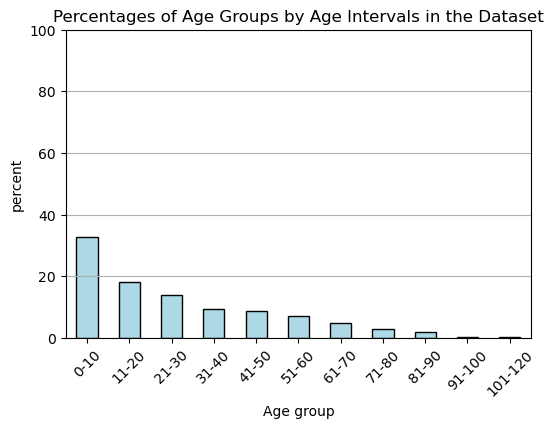

<IPython.core.display.Javascript object>

In [42]:
plt.figure(figsize=(6, 4))
age_group_percent.plot(kind="bar", color="lightblue", edgecolor="black")
plt.title("Percentages of Age Groups by Age Intervals in the Dataset")
plt.xlabel("Age group")
plt.ylabel("percent")
plt.xticks(
    ticks=range(len(age_intervals)),
    labels=[f"{interval[0]}-{interval[1]}" for interval in age_intervals],
    rotation=45,
)
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()

Also, it it was examined when images were collected to the dataset though this info will not be used for the modelling stage. The plot is presented bellow.

In [43]:
images_merged_info["datetime"] = images_merged_info["datetime"].str.slice(stop=-4)
images_merged_info["datetime"] = pd.to_datetime(
    images_merged_info["datetime"], format="%Y-%m-%d:%H:%M:%S"
)

<IPython.core.display.Javascript object>

In [44]:
images_merged_info["year"] = images_merged_info["datetime"].dt.year
images_merged_info["month"] = images_merged_info["datetime"].dt.month

<IPython.core.display.Javascript object>

In [45]:
year_counts = images_merged_info["year"].value_counts().sort_index()
month_counts = images_merged_info["month"].value_counts().sort_index()

<IPython.core.display.Javascript object>

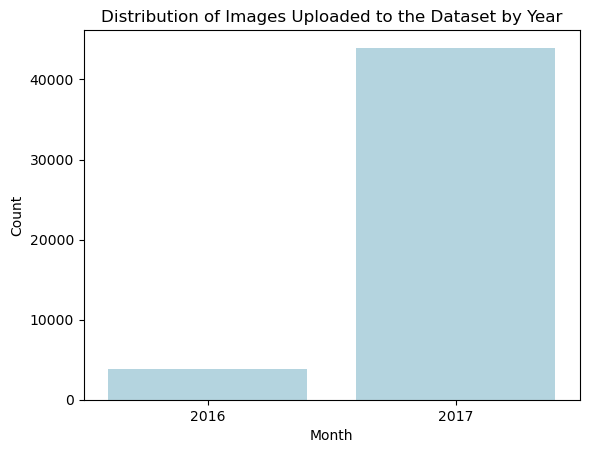

<IPython.core.display.Javascript object>

In [46]:
sns.barplot(x=year_counts.index, y=year_counts.values, color = 'lightblue')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Distribution of Images Uploaded to the Dataset by Year')
plt.show()


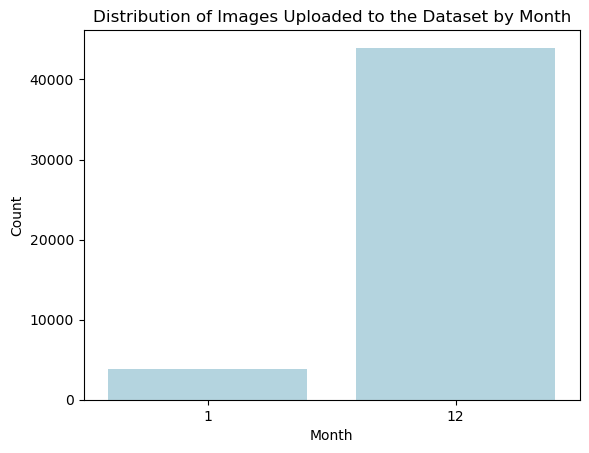

<IPython.core.display.Javascript object>

In [47]:
sns.barplot(x=month_counts.index, y=year_counts.values, color = 'lightblue')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Distribution of Images Uploaded to the Dataset by Month')
plt.show()


Now it is clear that the images to were uploader to the dataset in two months - December (2016) and January (2017). 

## 2. Modelling

In this part the process and results of transfer learning for the multi-task classification of face images are presented. As the pretained models of image classification that are used for building models which would be able to correctly predict gender and age of humans whose faces are presented in images were chosen Resnet18, Resnet50 and Resnet152. 

Other options to choose from the pretrained models for image classification such as VGGNet, Inception (GoogLeNet), DenseNet, EfficientNet, Xception, Transformer-based Models (e.g. Vision Transformers), etc., were considered but it was decided to limit the modelling to the Resnet group of models.


### Splitting the dataset into train and validation datasets


In the dataframe with the information on the merged folder of images the data in the column 'filename' were appended with the full directory path. Columns which would be used for model training (full_path, gender, and age) were selected and saved to the new dataframe 'image_merged'.

In [48]:
images_merged_info['full_path'] = images_merged_info['filename'].\
    apply(lambda x: os.path.join(dest_folder, x))


<IPython.core.display.Javascript object>

In [49]:
images_merged = images_merged_info[["full_path", "gender", "age"]]

<IPython.core.display.Javascript object>

In [50]:
images_merged.head()

full_path  gender  age
0  /Users/user/PycharmProjects/AdvancedDeepLearni...  female    9
1  /Users/user/PycharmProjects/AdvancedDeepLearni...    male   26
2  /Users/user/PycharmProjects/AdvancedDeepLearni...    male   36
3  /Users/user/PycharmProjects/AdvancedDeepLearni...    male   27
4  /Users/user/PycharmProjects/AdvancedDeepLearni...  female   86

<IPython.core.display.Javascript object>

As the numerical variable 'age' contained 0 values for the age period up to 1 year, in order to prevent multiplication or division by 0 issues, it was decided to recode 0 value to 0.5. The function 'convert_age_interval' was created and run.

In [51]:
def convert_age_interval(age: int) -> float:
    """
    Converts an integer age to a float age, representing the midpoint of the age interval.
    If the age is 0, the midpoint is returned as 0.5.

    Parameters:
        age (int): The age to be converted.

    Returns:
        float: The midpoint of the age interval.

    """
    if age == 0:
        return 0.5
    else:
        return float(age)

<IPython.core.display.Javascript object>

In [52]:
images_merged.loc[:, "age"] = images_merged.loc[:, "age"].apply(convert_age_interval)

<IPython.core.display.Javascript object>

The train dataframe is split into train (60 percent), validation (20 percent) and test (20 percent) datasets with the sklearn function train_test_split().


In [53]:
train_df, test_df = train_test_split(images_merged, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)


<IPython.core.display.Javascript object>

### Extracting images from the merged dataset

The class 'UTKFaceMergedDataset' for data importing and transforming to tensors was created. The class outputs tensors for images and their labels (gender and age). Training, validation, and test datasets were created as instances of this class.  

In [54]:
train_dataset = UTKFaceMergedDataset(dataframe=train_df, img_dir=dest_folder)
val_dataset = UTKFaceMergedDataset(dataframe=val_df, img_dir=dest_folder)
test_dataset = UTKFaceMergedDataset(dataframe=test_df, img_dir=dest_folder)


<IPython.core.display.Javascript object>

Here are examples of the use of the methods '__getitem__()' and '__len__()':

In [55]:
train_dataset[1]

(tensor([[[ 0.8789,  0.9132,  0.9132,  ...,  0.8961,  0.8961,  0.8961],
          [ 0.8789,  0.9132,  0.9132,  ...,  0.8961,  0.8961,  0.8961],
          [ 0.8789,  0.9132,  0.9132,  ...,  0.8961,  0.8961,  0.8961],
          ...,
          [-0.3198, -0.2513, -0.2513,  ..., -0.1657, -0.1314, -0.1486],
          [-0.3883, -0.3369, -0.3027,  ..., -0.1657, -0.1314, -0.1486],
          [-0.4054, -0.3541, -0.2684,  ..., -0.1657, -0.1314, -0.1486]],
 
         [[ 0.8529,  0.8880,  0.8880,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.8529,  0.8880,  0.8880,  ...,  0.9580,  0.9580,  0.9580],
          [ 0.8529,  0.8880,  0.8880,  ...,  0.9580,  0.9580,  0.9580],
          ...,
          [-0.2500, -0.1800, -0.1800,  ..., -0.1275, -0.0924, -0.1099],
          [-0.3200, -0.2675, -0.2325,  ..., -0.1275, -0.0924, -0.1099],
          [-0.3375, -0.2850, -0.1975,  ..., -0.1275, -0.0924, -0.1099]],
 
         [[ 1.0365,  1.0714,  1.0714,  ...,  1.1237,  1.1237,  1.1237],
          [ 1.0365,  1.0714,

<IPython.core.display.Javascript object>

In [56]:
len(train_dataset)

28689

<IPython.core.display.Javascript object>

The UTKFaceResNet​ class is created as a Pytorch Lightning module. This class initiates a pretrained Resnet model and applies it for multi-task classification of face images.
It also contains methods which are commonly included into Pytorch Lightning modules used for deep learning:
- forward (to pass the input x through the Resnet model and return the output),
- training_step (to compute the predicted output using the forward pass and calculate the losses),
- validation_step and test_step (to compute the losses for the given batch of data and log these metrics),
- configure_optimizers (to select optimizers),
- train_dataloader, val_dataloader and test_dataloader (to return data loaders for the training, validation and test datasets).
- test_epoch_end, on_train_epocch_end, and on_validation_epoch_end (to perform operations at the end of train and validation epochs and test outputs).

Some peculiartities of the class:
  - the class replaces the fully connected (fc) layer of a ResNet model (self.resnet.fc = nn.Identity()) with fully-conected liner layers fc_gender and fc_age;
 - the class gives an option to freeze (requires_grad = False) or unfreeze gradient calculation (for fine-tuning; requires_grad = True);
 - the class uses weights for calculating losses in the training stage in order to balance the imbalanced dataset;
 - the class collects various logs (for gender, age as well as combined);
 - the class uses AdamW optimizer as a more advanced version of Adam optimizer;
 - the class uses binary cross entropy function for gender (binary categorical variable) loss calculation and mean square error (MSE) function for age (numerical variable) loss calculation.

In [102]:
class UTKFaceResNet(pl.LightningModule):
    """
    PyTorch Lightning Module for training a ResNet model on the UTKFace dataset for age and gender prediction.
    """

    def __init__(
        self,
        batch_size: int,
        num_classes_gender: int,
        num_classes_age: int,
        weights_gender: float,
        weights_age: float,
        model: str,
        lr: float,
    ):
        """
        Initializes the UTKFaceResNet model.

        Args:
            batch_size (int): Batch size for training.
            num_classes_gender (int): Number of classes for gender prediction.
            num_classes_age (int): Number of classes for age prediction.
            weights_gender (float): Weight for gender loss.
            weights_age (float): Weight for age loss.
            model (str): Name of the ResNet model to be used.
            lr (float): Learning rate for the optimizer.
        """
        super().__init__()
        self.resnet = torch.hub.load("pytorch/vision", model, pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()

        self.fc_gender = nn.Linear(num_ftrs, num_classes_gender)
        self.fc_age = nn.Linear(num_ftrs, num_classes_age)

        self.weights_gender = weights_gender
        self.weights_age = weights_age
        self.batch_size = batch_size
        self.train_gender_losses = []
        self.train_age_losses = []
        self.val_gender_losses = []
        self.val_age_losses = []
        self.lr = lr

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input batch of images.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Predictions for gender and age.
        """
        features = self.resnet(x)
        gender_output = self.fc_gender(features)
        age_output = self.fc_age(features)
        return gender_output, age_output

    def configure_optimizers(self) -> optim.AdamW:
        """
        Configures the optimizer for training.

        Returns:
            optim.AdamW: AdamW optimizer with the set learning rate.
        """
        return optim.AdamW(
            [p for p in self.parameters() if p.requires_grad], lr=self.lr, eps=1e-08
        )

    def training_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """
        Training step for the model.

        Args:
            batch (Tuple[torch.Tensor, torch.Tensor, torch.Tensor]): Batch of images, genders, and ages.
            batch_idx (int): Index of the current batch.

        Returns:
            Dict[str, torch.Tensor]: Dictionary containing the weighted loss for gender and age, and the total weighted loss.
        """
        images, genders, ages = batch

        gender_preds, age_preds = self(images)

        gender_loss = F.binary_cross_entropy_with_logits(
            gender_preds.squeeze(), genders
        )
        weighted_gender_loss = gender_loss * self.weights_gender
        weighted_gender_loss = weighted_gender_loss.mean()

        age_loss = F.mse_loss(age_preds.squeeze(), ages)
        weighted_age_loss = age_loss * self.weights_age
        weighted_age_loss = weighted_age_loss.mean()

        weighted_loss = gender_loss + age_loss
        weighted_loss_dict = {
            "train_gender_loss": weighted_gender_loss,
            "train_age_loss": weighted_age_loss,
            "loss": weighted_loss,
        }
        self.train_gender_losses.append(gender_loss)
        self.train_age_losses.append(age_loss)
        self.log_dict(weighted_loss_dict)
        return weighted_loss_dict

    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """
        Validation step for the model.

        Args:
            batch (Tuple[torch.Tensor, torch.Tensor, torch.Tensor]): Batch of images, genders, and ages.
            batch_idx (int): Index of the current batch.

        Returns:
            Dict[str, torch.Tensor]: Dictionary containing the loss for gender and age, and the total loss.
        """
        images, genders, ages = batch
        gender_preds, age_preds = self.forward(images)

        gender_loss = F.binary_cross_entropy_with_logits(
            gender_preds.squeeze(), genders
        )
        age_loss = F.mse_loss(age_preds.squeeze(), ages)

        step_loss = gender_loss + age_loss
        step_loss_dict = {
            "val_gender_loss": gender_loss,
            "val_age_loss": age_loss,
            "loss": step_loss,
        }
        self.val_gender_losses.append(gender_loss)
        self.val_age_losses.append(age_loss)
        self.log_dict(step_loss_dict)
        return step_loss_dict

    def test_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> Dict[str, torch.Tensor]:
        """
        Test step for the model.

        Args:
            batch (Tuple[torch.Tensor, torch.Tensor, torch.Tensor]): Batch of images, genders, and ages.
            batch_idx (int): Index of the current batch.

        Returns:
            Dict[str, torch.Tensor]: Dictionary containing the loss for gender and age, and the total loss.
        """
        images, genders, ages = batch
        gender_preds, age_preds = self.forward(images)

        gender_loss = F.binary_cross_entropy_with_logits(
            gender_preds.squeeze(), genders
        )
        age_loss = F.mse_loss(age_preds.squeeze(), ages)

        step_loss = gender_loss + age_loss
        step_loss_dict = {
            "val_gender_loss": gender_loss,
            "val_age_loss": age_loss,
            "loss": step_loss,
        }

        self.log_dict(step_loss_dict)
        return step_loss_dict

    def on_train_epoch_end(self):
        """
        Performs operations at the end of each training epoch.
        """
        train_avg_gender_loss = torch.stack(self.train_gender_losses).mean()
        train_avg_age_loss = torch.stack(self.train_age_losses).mean()
        train_combined_loss = train_avg_gender_loss + train_avg_age_loss
        self.log_dict(
            {
                "avg_train_gender_loss": train_avg_gender_loss,
                "avg_train_age_loss": train_avg_age_loss,
                "train_combined_loss": train_combined_loss,
            }
        )

    def on_validation_epoch_end(self):
        """
        Performs operations at the end of each validation epoch.
        """
        val_avg_gender_loss = torch.stack(self.val_gender_losses).mean()
        val_avg_age_loss = torch.stack(self.val_age_losses).mean()
        val_combined_loss = val_avg_gender_loss + val_avg_age_loss

        self.log_dict(
            {
                "avg_val_gender_loss": val_avg_gender_loss,
                "avg_val_age_loss": val_avg_age_loss,
                "val_combined_loss": val_combined_loss,
            }
        )

    def test_epoch_end(self, outputs):
        """
        Performs operations on the outputs of the test data.

        Args:
            outputs (list): List of outputs from the test data.

        Returns:
            all_logits (torch.Tensor): Concatenated logits from all batches.
        """
        all_logits = torch.cat(outputs, dim=0)
        return all_logits

    def train_dataloader(self) -> DataLoader:
        """
        Returns a DataLoader object for training data.

        Returns:
            A DataLoader object for training data.
        """
        return DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=6,
        )

    def val_dataloader(self) -> DataLoader:
        """
        Returns a DataLoader object for validation data.

        Returns:
            A DataLoader object for validation data.
        """
        return DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=6,
        )

    def test_dataloader(self) -> DataLoader:
        """
        Returns a DataLoader object for testing data.

        Returns:
            A DataLoader object for testing data.
        """
        return DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=6,
        )

<IPython.core.display.Javascript object>

The weights for gender and age are set by sklearn function 'compute_sample_weight()', weights are transformed to tensors.

In [103]:
weights_gender = compute_sample_weight("balanced", 
                                      images_merged["gender"])
weights_gender = torch.tensor(weights_gender, dtype=torch.float32)

weights_age = compute_sample_weight('balanced',
                                   images_merged["age"])
weights_age = torch.tensor(weights_age, dtype=torch.float32)



<IPython.core.display.Javascript object>

As the six models with different combinations of parameters would be trained in total (models with three resnet models - resnet18, resnet50 and resnet152 - and two learning rates - 0.001 and 0.0001), lists of learning rates and model names were created to represent these combinations.

In [104]:
lr_list = [0.001, 0.0001, 0.001, 0.0001, 0.001, 0.0001]

<IPython.core.display.Javascript object>

In [105]:
model_list = []
model_name_list = []
resnet_name_list = [
    "resnet18",
    "resnet18",
    "resnet50",
    "resnet50",
    "resnet152",
    "resnet152",
]

<IPython.core.display.Javascript object>

The batch size was set to 5 (rather small one) in order to avoid overload of memory during the training processes.

In [106]:
batch_size = 5


<IPython.core.display.Javascript object>

Number of classes parameters were set for gender and age. 1 is the choice for gender because its a one class with two values (0 and 1). For age variable 1 class is chosen because it is a numerical variable with number of integer values.

In [107]:
num_classes_gender = 1
num_classes_age = 1

<IPython.core.display.Javascript object>

Models with different parameters are instatiated on the UTKFaceResNet class defined above in the loop over elements of previously defined lists. Instantiated models were appended to a list.

In [108]:
for resnet_name, lr in zip(resnet_name_list, lr_list):
    model = UTKFaceResNet(
        batch_size,
        num_classes_gender,
        num_classes_age,
        weights_gender,
        weights_age,
        resnet_name,
        lr,
    )
    model_name = f"{resnet_name}_{lr}"
    model_name_list.append(model_name)
    model_list.append(model)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


<IPython.core.display.Javascript object>

Summaries of the models are presented bellow.

In [109]:
for model, model_name in zip(model_list, model_name_list):
    print(f"{model_name}")
    print(f"{summary(model, (3, 256, 256))}")
    print("")

resnet18_0.001
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

<IPython.core.display.Javascript object>

The models were trained on the Mac computer with the M2 processor which 10 GPU cores, thus, the GPU use was assigned to each model as well as to the weights of gender and age.

In [110]:
for model in model_list:
    device = torch.device("mps")
    model.weights_gender = weights_gender.to(device)
    model.weights_age = weights_age.to(device)
    model.to(device)

<IPython.core.display.Javascript object>

Tensorboard_logger is a tool that helps visualize and track the training process of a machine learning model. In this case, the TensorBoardLogger is used to store the logs and results of a multi-label classification model in a specific directory ("./tb_logs") (see bellow). 

In [111]:
tensorboard_logger = pl.loggers.TensorBoardLogger("tb_logs", name="my_model")

<IPython.core.display.Javascript object>

### Specifying callbacks

Several callback functions were created, instantiated and included as parameters in the model training:

- checkpoint callback function is used to save model training information after each epoch (it is useful in the cases when the training process is interrupted; then it could be started by loading the model lastly saved to the checkpoint;
- The early_stopping_callback is a callback function that is used to stop the training process early if the validation loss does not improve for a certain number of epochs. Also, a callback class for calculating training time is created and instantiated as a callback;
- the epoch_time_callback function is used to store information about time used for training of each epoch.

In [112]:
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor="val_combined_loss", patience=3, mode="min"
)

<IPython.core.display.Javascript object>

In [113]:

checkpoint_callback = ModelCheckpoint(
        dirpath="models/",
        filename=f'resnet152_tuned_0.001_tuned_{{epoch}}-{{val_combined_loss:.2f}}',
        monitor="val_combined_loss",
        save_top_k=3,
        mode="min",
        every_n_epochs=1,
    )


<IPython.core.display.Javascript object>

In [114]:
class ValidationLogCollectorCallback(pl.Callback):
    """
    A PyTorch Lightning callback that collects validation metrics at the end of each validation epoch.
    """

    def __init__(self):
        """
        Initializes the ValidationLogCollectorCallback.
        """
        super().__init__()
        self.validation_metrics = []

    def on_validation_epoch_end(
        self, trainer: pl.Trainer, pl_module: pl.LightningModule
    ):
        """
        Collects the validation metrics at the end of each validation epoch.

        Args:
            trainer (pl.Trainer): The PyTorch Lightning trainer object.
            pl_module (pl.LightningModule): The PyTorch Lightning module being trained.
        """
        metrics = trainer.callback_metrics
        self.validation_metrics.append(metrics)

    def get_metrics_dataframe(self) -> pd.DataFrame:
        """
        Returns a Pandas DataFrame containing the collected validation metrics.

        Returns:
            pd.DataFrame: A Pandas DataFrame containing the collected validation metrics.
        """
        return pd.DataFrame(self.validation_metrics)

<IPython.core.display.Javascript object>

In [115]:
class EpochTimeCallback(pl.Callback):
    """
    A PyTorch Lightning callback to measure and store the duration of each epoch.
    
    Attributes:
    epoch_times_df (pd.DataFrame): A dataframe containing epoch numbers and their corresponding durations.
    """

    def __init__(self):
        """Initializes the callback and sets up an empty dataframe to store epoch times."""
        super().__init__()
        self.epoch_times_df: pd.DataFrame = pd.DataFrame(columns=['Epoch', 'Duration'])

    def on_epoch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """
        Record the start time of the epoch.

        Args:
        trainer (pl.Trainer): The trainer object.
        pl_module (pl.LightningModule): The model/module being trained.
        """
        self.epoch_start_time = time.time()

    def on_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """
        Calculate and store the duration of the epoch, and print the epoch duration.

        Args:
        trainer (pl.Trainer): The trainer object.
        pl_module (pl.LightningModule): The model/module being trained.
        """
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        epoch = trainer.current_epoch + 1

        self.epoch_times_df.loc[len(self.epoch_times_df)] = [epoch, epoch_duration]
        print(f"Epoch {epoch} execution time: {epoch_duration:.2f} seconds")

    def get_epoch_times_df(self) -> pd.DataFrame:
        """
        Retrieve the dataframe containing epoch durations.

        Returns:
        pd.DataFrame: A dataframe containing epoch numbers and their corresponding durations.
        """
        return self.epoch_times_df


<IPython.core.display.Javascript object>

In [116]:
log_collector = ValidationLogCollectorCallback()

<IPython.core.display.Javascript object>

In [117]:
epoch_time_callback = EpochTimeCallback()

<IPython.core.display.Javascript object>

### Training the model

The dictionary to save information on times for processes of training, fine-tuning, validation, testing and prediction is created.

In [118]:
metrics_df = {}
metrics_df["model_name"] = []
metrics_df["train_time"] = []
metrics_df["tune_time"] = []
metrics_df["validation_time"] = []
metrics_df["test_time"] = []
metrics_df["val_prediction_time"] = []
metrics_df["test_prediction_time"] = []

trainer_list = []

<IPython.core.display.Javascript object>

Initially, the models from the model list were trained with teh gradient calculation freezed and with the set maximum size of 10 epochs. The training process was interrupted several times, and the training proceded by loading the last saved model. (Unfortunately, the timing information was lost because the dictionary with the appended data was not saved to the local computer).  

For some of the models the early stopping callback was executed in order to prevent overfitting. 

In [60]:
for model, resnet_name, lr, model_name in zip(
    model_list[5:], resnet_name_list[5:], lr_list[5:], model_name_list[5:]
):
    last_checkpoint_path = f"models/UTKFace_trained_{model_name}.ckpt"

    model = UTKFaceResNet.load_from_checkpoint(
        checkpoint_path=last_checkpoint_path,
        batch_size=batch_size,
        num_classes_gender=num_classes_gender,
        num_classes_age=num_classes_age,
        weights_gender=weights_gender,
        weights_age=weights_age,
        model=resnet_name,
        lr=lr,
    )

    device = torch.device("mps")
    model.weights_gender = weights_gender.to(device)
    model.weights_age = weights_age.to(device)
    model.to(device)

    start_time = time.time()
    trainer = pl.Trainer(
        max_epochs=10,
        logger=tensorboard_logger,
        callbacks=[
            checkpoint_callback,
            log_collector,
            early_stopping_callback,
            epoch_time_callback,
        ],
    )
    trainer.fit(
        model, DataLoader(train_dataset, batch_size), ckpt_path=last_checkpoint_path
    )
    trainer_list.append(trainer)
    end_time = time.time()
    exec_time = (end_time - start_time) / len(train_dataset)
    print("")
    print(f"Model_name: {model_name}")
    print(f"Execution time: {exec_time}")
    metrics_df["model_name"].append(model_name)
    metrics_df["train_time"].append(exec_time)
    checkpoint_path = f"models/UTKFace_trained_{model_name}.ckpt"
    trainer.save_checkpoint(checkpoint_path)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at models/UTKFace_trained_resnet152_0.0001.ckpt

  | Name      | Type   | Params
-------------------------------------
0 | resnet    | ResNet | 58.1 M
1 | fc_gender | Linear | 2.0 K 
2 | fc_age    | Linear | 2.0 K 
-------------------------------------
4.1 K     Trainable params
58.1 M    Non-trainable params
58.1 M    Total params
232.592   Total estimated model params size (MB)
Restored all states from the checkpoint at models/UTKFace_trained_resnet152_0.0001.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


Validation: 0it [00:00, ?it/s]


Model_name: resnet152_0.0001
Execution time: 0.03714495318677818


<IPython.core.display.Javascript object>

It can be seen that to the training of the resnet152 model with the learning rate 0.0001 took 0.03 seconds per image (total training time divided by the number of images).

### Fine-tuning the model

After the training without gradient calculation ended, the models were uploaded one by one to be fine-tuned (unfreezing layers of the models for gradient calculation). The maximum size of epochs for fin-tuning was set to 30. For resnet18 (both with learning rate 0.001 and 0.0001) the fine-tuning process stopped after the first epochs due to the instantiation of the early-stopping callback. 

For the resnet50 and resnet 152 with the learning rate 0.001 the early-stopping callback was never instantiated and the models were trained for the maximum number of epochs (30). For the resnet50 and resnet152 with the learning rate 0.001 the fin-tuning process was stopped by the early stopping callback after two epochs. 


In [75]:
model_name_list[4:5]

['resnet152_0.001']

<IPython.core.display.Javascript object>

In [120]:
for resnet_name, lr, model_name in zip(
    resnet_name_list[4:5], lr_list[4:5], model_name_list[4:5]
):
    last_checkpoint_path = f"models/UTKFace_trained_{model_name}.ckpt"

    model = UTKFaceResNet.load_from_checkpoint(
        checkpoint_path=last_checkpoint_path,
        batch_size=batch_size,
        num_classes_gender=num_classes_gender,
        num_classes_age=num_classes_age,
        weights_gender=weights_gender,
        weights_age=weights_age,
        model=resnet_name,
        lr=lr,
    )

    device = torch.device("mps")
    model.weights_gender = weights_gender.to(device)
    model.weights_age = weights_age.to(device)
    model.to(device)

    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=lr)

    start_time = time.time()
    trainer = pl.Trainer(
        max_epochs=30,
        logger=tensorboard_logger,
        callbacks=[
            checkpoint_callback,
            log_collector,
            early_stopping_callback,
            epoch_time_callback,
        ],
    )
    trainer.fit(
        model,
        DataLoader(train_dataset, batch_size),
        # ckpt_path=last_checkpoint_path
    )
    end_time = time.time()
    exec_time = (end_time - start_time) / len(train_dataset)
    print("")
    print(f"Model_name: {model_name}")
    print(f"Execution time: {exec_time}")
    metrics_df["tune_time"].append(exec_time)
    checkpoint_path = f"models/UTKFace_tuned_{model_name}.ckpt"
    trainer.save_checkpoint(checkpoint_path)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type   | Params
-------------------------------------
0 | resnet    | ResNet | 58.1 M
1 | fc_gender | Linear | 2.0 K 
2 | fc_age    | Linear | 2.0 K 
-------------------------------------
58.1 M    Trainable params
0         Non-trainable params
58.1 M    Total params
232.592   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


RuntimeError: MPS backend out of memory (MPS allocated: 8.32 GB, other allocations: 758.39 MB, max allowed: 9.07 GB). Tried to allocate 3.83 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

<IPython.core.display.Javascript object>

It can be seen that the fine-tuning of the resnet50 model with the learning rate 0.0001 took 0.02 seconds per image (total training time divided by the number of images) and fin-tuning of the resnet152 with the learning rate 0.001 took 0.9 and with the learning rate 0.0001 0.04 seconds per image.

### Assessment of the models and predictions

The model performance was assessed with the functions trainer.validate() for both the validation and test datasets. The outputs of assessment are presented bellow.


#### Model assessments:

In [727]:
for resnet_name, lr, model_name in zip(
    resnet_name_list, lr_list, model_name_list
):
    checkpoint_path = f"models/UTKFace_tuned_{model_name}.ckpt"
    model = UTKFaceResNet.load_from_checkpoint(
        checkpoint_path=checkpoint_path,
        batch_size=batch_size,
        num_classes_gender=num_classes_gender,
        num_classes_age=num_classes_age,
        weights_gender=weights_gender,
        weights_age=weights_age,
        model=resnet_name,
        lr=lr,
    )

    device = torch.device("mps")
    model.to(device)
    start_time = time.time()
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    trainer = pl.Trainer()
    metrics = trainer.validate(model=model, dataloaders=val_dataloader)
    end_time = time.time()
    exec_time = (end_time - start_time) / len(val_dataset)
    print(f"{model_name}")
    print(f"Execution time: {exec_time}")
    # metrics_df["val_time"].append(exec_time)
    print(metrics)
    print("")

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │    191.63645935058594     │
│    avg_val_gender_loss    │    0.3638207018375397     │
│           loss            │     191.9447479248047     │
│       val_age_loss        │    191.58082580566406     │
│     val_combined_loss     │    192.00027465820312     │
│      val_gender_loss      │    0.36383941769599915    │
└───────────────────────────┴───────────────────────────┘

resnet18_0.001
Execution time: 0.006034789743077414
[{'val_gender_loss': 0.36383941769599915, 'val_age_loss': 191.58082580566406, 'loss': 191.9447479248047, 'avg_val_gender_loss': 0.3638207018375397, 'avg_val_age_loss': 191.63645935058594, 'val_combined_loss': 192.00027465820312}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │    191.63645935058594     │
│    avg_val_gender_loss    │    0.3638207018375397     │
│           loss            │     191.9447479248047     │
│       val_age_loss        │    191.58082580566406     │
│     val_combined_loss     │    192.00027465820312     │
│      val_gender_loss      │    0.36383941769599915    │
└───────────────────────────┴───────────────────────────┘

resnet18_0.0001
Execution time: 0.0055328010079203245
[{'val_gender_loss': 0.36383941769599915, 'val_age_loss': 191.58082580566406, 'loss': 191.9447479248047, 'avg_val_gender_loss': 0.3638207018375397, 'avg_val_age_loss': 191.63645935058594, 'val_combined_loss': 192.00027465820312}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │    174.27195739746094     │
│    avg_val_gender_loss    │     0.355009526014328     │
│           loss            │    174.62948608398438     │
│       val_age_loss        │     174.2743682861328     │
│     val_combined_loss     │    174.62696838378906     │
│      val_gender_loss      │    0.35506516695022583    │
└───────────────────────────┴───────────────────────────┘

resnet50_0.001
Execution time: 0.008802806335077443
[{'val_gender_loss': 0.35506516695022583, 'val_age_loss': 174.2743682861328, 'loss': 174.62948608398438, 'avg_val_gender_loss': 0.355009526014328, 'avg_val_age_loss': 174.27195739746094, 'val_combined_loss': 174.62696838378906}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │     210.0821990966797     │
│    avg_val_gender_loss    │    0.37357044219970703    │
│           loss            │    210.44688415527344     │
│       val_age_loss        │    210.07293701171875     │
│     val_combined_loss     │     210.4557647705078     │
│      val_gender_loss      │    0.3735969662666321     │
└───────────────────────────┴───────────────────────────┘

resnet50_0.0001
Execution time: 0.009792319030227191
[{'val_gender_loss': 0.3735969662666321, 'val_age_loss': 210.07293701171875, 'loss': 210.44688415527344, 'avg_val_gender_loss': 0.37357044219970703, 'avg_val_age_loss': 210.0821990966797, 'val_combined_loss': 210.4557647705078}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │    181.02706909179688     │
│    avg_val_gender_loss    │    0.33908554911613464    │
│           loss            │    181.31471252441406     │
│       val_age_loss        │    180.97561645507812     │
│     val_combined_loss     │    181.36614990234375     │
│      val_gender_loss      │    0.3391196131706238     │
└───────────────────────────┴───────────────────────────┘

resnet152_0.001
Execution time: 0.04974603503365952
[{'val_gender_loss': 0.3391196131706238, 'val_age_loss': 180.97561645507812, 'loss': 181.31471252441406, 'avg_val_gender_loss': 0.33908554911613464, 'avg_val_age_loss': 181.02706909179688, 'val_combined_loss': 181.36614990234375}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │     225.919677734375      │
│    avg_val_gender_loss    │    0.37724950909614563    │
│           loss            │    226.27279663085938     │
│       val_age_loss        │    225.89572143554688     │
│     val_combined_loss     │     226.2969207763672     │
│      val_gender_loss      │    0.3772891163825989     │
└───────────────────────────┴───────────────────────────┘

resnet152_0.0001
Execution time: 0.05023720517986728
[{'val_gender_loss': 0.3772891163825989, 'val_age_loss': 225.89572143554688, 'loss': 226.27279663085938, 'avg_val_gender_loss': 0.37724950909614563, 'avg_val_age_loss': 225.919677734375, 'val_combined_loss': 226.2969207763672}]



In [733]:
for resnet_name, lr, model_name in zip(
    resnet_name_list, lr_list, model_name_list
):
    checkpoint_path = f"models/UTKFace_tuned_{model_name}.ckpt"
    model = UTKFaceResNet.load_from_checkpoint(
        checkpoint_path=checkpoint_path,
        batch_size=batch_size,
        num_classes_gender=num_classes_gender,
        num_classes_age=num_classes_age,
        weights_gender=weights_gender,
        weights_age=weights_age,
        model=resnet_name,
        lr=lr,
    )
    device = torch.device("mps")
    model.to(device)
    start_time = time.time()
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    trainer = pl.Trainer()
    metrics = trainer.validate(model=model, dataloaders=test_dataloader)
    end_time = time.time()
    exec_time = (end_time - start_time) / len(test_dataset)
    print(f"{model_name}")
    print(f"Execution time: {exec_time}")
    # metrics_df["val_time"].append(exec_time)
    print(metrics)
    print("")

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │    189.59439086914062     │
│    avg_val_gender_loss    │    0.35499897599220276    │
│           loss            │     189.955810546875      │
│       val_age_loss        │     189.600830078125      │
│     val_combined_loss     │     189.9493865966797     │
│      val_gender_loss      │    0.35501930117607117    │
└───────────────────────────┴───────────────────────────┘

resnet18_0.001
Execution time: 0.005864931843062416
[{'val_gender_loss': 0.35501930117607117, 'val_age_loss': 189.600830078125, 'loss': 189.955810546875, 'avg_val_gender_loss': 0.35499897599220276, 'avg_val_age_loss': 189.59439086914062, 'val_combined_loss': 189.9493865966797}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │    189.59439086914062     │
│    avg_val_gender_loss    │    0.35499897599220276    │
│           loss            │     189.955810546875      │
│       val_age_loss        │     189.600830078125      │
│     val_combined_loss     │     189.9493865966797     │
│      val_gender_loss      │    0.35501930117607117    │
└───────────────────────────┴───────────────────────────┘

resnet18_0.0001
Execution time: 0.0055408945197293275
[{'val_gender_loss': 0.35501930117607117, 'val_age_loss': 189.600830078125, 'loss': 189.955810546875, 'avg_val_gender_loss': 0.35499897599220276, 'avg_val_age_loss': 189.59439086914062, 'val_combined_loss': 189.9493865966797}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │     176.1654052734375     │
│    avg_val_gender_loss    │    0.33763718605041504    │
│           loss            │     176.4934539794922     │
│       val_age_loss        │     176.1558074951172     │
│     val_combined_loss     │    176.50303649902344     │
│      val_gender_loss      │    0.33763277530670166    │
└───────────────────────────┴───────────────────────────┘

resnet50_0.001
Execution time: 0.03998705529109647
[{'val_gender_loss': 0.33763277530670166, 'val_age_loss': 176.1558074951172, 'loss': 176.4934539794922, 'avg_val_gender_loss': 0.33763718605041504, 'avg_val_age_loss': 176.1654052734375, 'val_combined_loss': 176.50303649902344}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │    210.23751831054688     │
│    avg_val_gender_loss    │    0.36237725615501404    │
│           loss            │    210.60877990722656     │
│       val_age_loss        │     210.2465057373047     │
│     val_combined_loss     │     210.5998992919922     │
│      val_gender_loss      │    0.3623969256877899     │
└───────────────────────────┴───────────────────────────┘

resnet50_0.0001
Execution time: 0.04103066805564724
[{'val_gender_loss': 0.3623969256877899, 'val_age_loss': 210.2465057373047, 'loss': 210.60877990722656, 'avg_val_gender_loss': 0.36237725615501404, 'avg_val_age_loss': 210.23751831054688, 'val_combined_loss': 210.5998992919922}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │     183.209716796875      │
│    avg_val_gender_loss    │    0.3343577980995178     │
│           loss            │      183.55322265625      │
│       val_age_loss        │    183.21888732910156     │
│     val_combined_loss     │     183.5440673828125     │
│      val_gender_loss      │    0.33439019322395325    │
└───────────────────────────┴───────────────────────────┘

resnet152_0.001
Execution time: 0.0188980913969923
[{'val_gender_loss': 0.33439019322395325, 'val_age_loss': 183.21888732910156, 'loss': 183.55322265625, 'avg_val_gender_loss': 0.3343577980995178, 'avg_val_age_loss': 183.209716796875, 'val_combined_loss': 183.5440673828125}]



Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     avg_val_age_loss      │     225.989501953125      │
│    avg_val_gender_loss    │     0.368653804063797     │
│           loss            │    226.37350463867188     │
│       val_age_loss        │    226.00469970703125     │
│     val_combined_loss     │     226.358154296875      │
│      val_gender_loss      │    0.3686801791191101     │
└───────────────────────────┴───────────────────────────┘

resnet152_0.0001
Execution time: 0.020501849941507336
[{'val_gender_loss': 0.3686801791191101, 'val_age_loss': 226.00469970703125, 'loss': 226.37350463867188, 'avg_val_gender_loss': 0.368653804063797, 'avg_val_age_loss': 225.989501953125, 'val_combined_loss': 226.358154296875}]



#### Predictions:

Predictions were generated on the preprocessed validation and test data. For the gender variable logits were generated by looping over batches of validation and test data. From logits probalities were calculated with the sigmoid function. Based of the threshold, values with probabilities higher than 0.5 got the value 1 (female) and values lower thatn 0.5 got the value 1. The values were appended to the lists. 

For the age variable, predictions were generated directly and also appended to the lists. 

In [734]:
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=3
)

In [796]:
predictions_val_gender_list = []
predictions_val_age_list = []
y_true_val_gender_list = []
y_true_val_age_list = []

for resnet_name, lr, model_name in zip(
    resnet_name_list, lr_list, model_name_list
):
    gender_predictions = []
    age_predictions = []
    y_true_gender = []
    y_true_age = []

    checkpoint_path = f"models/UTKFace_tuned_{model_name}.ckpt"
    model = UTKFaceResNet.load_from_checkpoint(
        checkpoint_path=checkpoint_path,
        batch_size=batch_size,
        num_classes_gender=num_classes_gender,
        num_classes_age=num_classes_age,
        weights_gender=weights_gender,
        weights_age=weights_age,
        model=resnet_name,
        lr=lr,
    )
    device = torch.device("cpu")
    model.to(device)

    start_time = time.time()
    with torch.no_grad():
        for data, gender_label, age_label in DataLoader(val_dataset, batch_size=batch_size, 
                                                        shuffle=False, num_workers=6):
            gender_logits, age_pred = model(data)
            gender_proba = F.sigmoid(gender_logits).squeeze() 
            gender_hat = (gender_proba > 0.5).long()  
            age_hat = age_pred.squeeze()
            gender_predictions.append(gender_hat.tolist())
            age_predictions.append(age_hat.tolist())
            y_true_gender.append(gender_label.tolist())
            y_true_age.append(age_label.tolist())

        predictions_val_gender_list.append((gender_predictions))
        y_true_val_gender_list.append((y_true_gender))
        predictions_val_age_list.append((age_predictions))
        y_true_val_age_list.append((y_true_age))

    end_time = time.time()
    exec_time = (end_time - start_time)/len(val_dataset)
    print(f'{model_name}')
    print(f'Prediction time: {exec_time}')
    metrics_df["val_prediction_time"].append(exec_time)


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet18_0.001
Prediction time: 0.019365638391649724


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet18_0.0001
Prediction time: 0.019201698929498377


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet50_0.001
Prediction time: 0.033847733221081006


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet50_0.0001
Prediction time: 0.03227768534710501


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet152_0.001
Prediction time: 0.06784448301544077


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet152_0.0001
Prediction time: 0.06656383236469515


In [736]:
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [739]:
predictions_test_gender_list = []
y_true_test_gender_list = []
predictions_test_age_list = []
y_true_test_age_list = []

for resnet_name, lr, model_name in zip(
    resnet_name_list, lr_list, model_name_list
):
    gender_predictions = []
    age_predictions = []
    y_true_gender = []
    y_true_age = []

    checkpoint_path = f"models/UTKFace_tuned_{model_name}.ckpt"
    model = UTKFaceResNet.load_from_checkpoint(
        checkpoint_path=checkpoint_path,
        batch_size=batch_size,
        num_classes_gender=num_classes_gender,
        num_classes_age=num_classes_age,
        weights_gender=weights_gender,
        weights_age=weights_age,
        model=resnet_name,
        lr=lr,
    )
    device = torch.device("cpu")
    model.to(device)
    start_time = time.time()
    with torch.no_grad():
        for data, gender_label, age_label in DataLoader(val_dataset, batch_size=batch_size, 
                                                        shuffle=False, num_workers=6):
            gender_logits, age_pred = model(data)
            gender_proba = F.sigmoid(gender_logits).squeeze()  
            gender_hat = (gender_proba > 0.5).long()
            age_hat = age_pred.squeeze()
            
            gender_predictions.append(gender_hat.tolist())
            age_predictions.append(age_hat.tolist())
            y_true_gender.append(gender_label.tolist())
            y_true_age.append(age_label.tolist())
            
        predictions_test_gender_list.append((gender_predictions))
        y_true_test_gender_list.append((y_true_gender))
        predictions_test_age_list.append((age_predictions))
        y_true_test_age_list.append((y_true_age))

    end_time = time.time()
    test_prediction_time = (end_time - start_time)/len(test_dataset)
    print(f'{model_name}')
    print(f'Prediction time: {test_prediction_time}')
    metrics_df["test_prediction_time"].append(test_prediction_time)


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet18_0.001
Prediction time: 0.01905915862793007


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet18_0.0001
Prediction time: 0.019134013785422472


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet50_0.001
Prediction time: 0.031773815963718


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet50_0.0001
Prediction time: 0.031925269770652166


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet152_0.001
Prediction time: 0.06424879890662863


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


resnet152_0.0001
Prediction time: 0.06398562221335646


The dictionary containing information on timing was saved into a local file.

In [802]:
with open("metrics_df.pkl", "wb") as fp:
    pickle.dump(metrics_df, fp)
    print("The dictionary saved to a file.")

The dictionary saved to a file.


### Visualizing losses

Training metrics are visualized on the tensorboard dashboard.

In [ ]:
!tensorboard --logdir=/Users/user/PycharmProjects/AdvancedDeepLearning

### Comparing and visualizing metrics of the models

In this step, comparisons of metrics of six trained and fine-tuned models are provided. First, the dataframe (created from the metrics created by the class method) presents comparative data losses of validation and test datasets, also time used for training and prediction.

In [805]:
logs_df = pd.DataFrame(log_collector.get_metrics_dataframe())
logs_df.head(5)

val_gender_loss                      val_age_loss  \
0  tensor(0.4473, device='mps:0')  tensor(327.6795, device='mps:0')   
1  tensor(0.3736, device='mps:0')  tensor(210.0729, device='mps:0')   
2  tensor(0.2223, device='mps:0')  tensor(271.3697, device='mps:0')   
3  tensor(0.3391, device='mps:0')  tensor(180.9756, device='mps:0')   
4  tensor(0.3391, device='mps:0')  tensor(180.9756, device='mps:0')   

                               loss             avg_val_gender_loss  \
0  tensor(328.1268, device='mps:0')  tensor(0.4473, device='mps:0')   
1  tensor(210.4469, device='mps:0')  tensor(0.3736, device='mps:0')   
2  tensor(271.5920, device='mps:0')  tensor(0.2223, device='mps:0')   
3  tensor(181.3147, device='mps:0')  tensor(0.3398, device='mps:0')   
4  tensor(181.3147, device='mps:0')  tensor(0.3398, device='mps:0')   

                   avg_val_age_loss                 val_combined_loss  \
0  tensor(327.6795, device='mps:0')  tensor(328.1268, device='mps:0')   
1  tensor(210.2050, device='mps:0')  tensor(210.5787, device='mps:0')   
2  tensor(271.3697, device='mps:0')  tensor(271.5920, device='mps:0')   
3  tensor(182.8102, device='mps:0')  tensor(183.1501, device='mps:0')   
4  tensor(182.8102, device='mps:0')  tensor(183.1501, device='mps:0')   

                train_gender_loss                    train_age_loss  \
0                             NaN                               NaN   
1  tensor(0.2970, device='mps:0')   tensor(94.2058, device='mps:0')   
2                             NaN                               NaN   
3  tensor(0.4782, device='mps:0')  tensor(147.5259, device='mps:0')   
4  tensor(0.4782, device='mps:0')  tensor(147.5259, device='mps:0')   

            avg_train_gender_loss                avg_train_age_loss  \
0                             NaN                               NaN   
1  tensor(0.4523, device='mps:0')  tensor(255.3316, device='mps:0')   
2                             NaN                               NaN   
3  tensor(0.4326, device='mps:0')  tensor(212.0468, device='mps:0')   
4  tensor(0.4326, device='mps:0')  tensor(212.0468, device='mps:0')   

                train_combined_loss  
0                               NaN  
1  tensor(255.7839, device='mps:0')  
2                               NaN  
3  tensor(212.4794, device='mps:0')  
4  tensor(212.4794, device='mps:0')

The dictionary presents data on the fine-tuning and prediction times per one image for various models. The data are incomplete because of interruptions during the training process.

In [806]:
metrics_df

{'model_name': [],
 'train_time': [],
 'tune_time': [0.020291113363968924, 0.9131098509524607, 0.041816300257820724],
 'validation_time': [],
 'test_time': [],
 'val_prediction_time': [0.019173132803578963,
  0.01896480552623876,
  0.031388286091749554,
  0.03143132073253714,
  0.0638211821582319,
  0.06372087617355773,
  0.019365638391649724,
  0.019201698929498377,
  0.033847733221081006,
  0.03227768534710501,
  0.06784448301544077,
  0.06656383236469515],
 'test_prediction_time': [0.01905915862793007,
  0.019134013785422472,
  0.031773815963718,
  0.031925269770652166,
  0.06424879890662863,
  0.06398562221335646]}

### Classification reports for gender predictions

Classification reports for the gender predictions were created for the all six models. First, the lists containing sublists on batches of data were flattened for all models and both for validation and test data sets. 

In [826]:
pred_val_gender_flat_list = []
y_true_val_gender_flat_list = []
for lst1, lst2 in zip(predictions_val_gender_list, y_true_val_gender_list):
    pred_flat_list = list(itertools.chain.from_iterable(lst1))
    ytrue_flat_list = list(itertools.chain.from_iterable(lst2))
    
    pred_val_gender_flat_list.append(pred_flat_list)
    y_true_val_gender_flat_list.append(ytrue_flat_list)

In [827]:
pred_test_gender_flat_list = []
y_true_test_gender_flat_list = []
for lst1, lst2 in zip(predictions_test_gender_list, y_true_test_gender_list):
    pred_flat_list = list(itertools.chain.from_iterable(lst1))
    ytrue_flat_list = list(itertools.chain.from_iterable(lst2))
    
    pred_test_gender_flat_list.append(pred_flat_list)
    y_true_test_gender_flat_list.append(ytrue_flat_list)

The classification reports are presented bellow.

In [828]:
for pred, ytrue, model_name in zip(pred_val_gender_flat_list, y_true_val_gender_flat_list, model_name_list):
    print(f'{model_name}')
    from sklearn.metrics import classification_report
    classification_report = classification_report(ytrue, pred)
    print(classification_report)
    print('')

resnet18_0.001
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      4946
         1.0       0.78      0.76      0.77      4617

    accuracy                           0.78      9563
   macro avg       0.78      0.78      0.78      9563
weighted avg       0.78      0.78      0.78      9563


resnet18_0.0001
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      4946
         1.0       0.78      0.76      0.77      4617

    accuracy                           0.78      9563
   macro avg       0.78      0.78      0.78      9563
weighted avg       0.78      0.78      0.78      9563


resnet50_0.001
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82      4946
         1.0       0.84      0.74      0.79      4617

    accuracy                           0.81      9563
   macro avg       0.81      0.81      0.81      9563
weighted avg       0.81   

In [829]:
for pred, ytrue, model_name in zip(pred_test_gender_flat_list, y_true_test_gender_flat_list, model_name_list):
    print(f'{model_name}')
    from sklearn.metrics import classification_report
    classification_report = classification_report(ytrue, pred)
    print(classification_report)
    print('')

resnet18_0.001
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      4946
         1.0       0.78      0.76      0.77      4617

    accuracy                           0.78      9563
   macro avg       0.78      0.78      0.78      9563
weighted avg       0.78      0.78      0.78      9563


resnet18_0.0001
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      4946
         1.0       0.78      0.76      0.77      4617

    accuracy                           0.78      9563
   macro avg       0.78      0.78      0.78      9563
weighted avg       0.78      0.78      0.78      9563


resnet50_0.001
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82      4946
         1.0       0.84      0.74      0.79      4617

    accuracy                           0.81      9563
   macro avg       0.81      0.81      0.81      9563
weighted avg       0.81   

It can be observed that models resent50_0.001 and resnet152_0.001 provide the best scores. 

### Confusion matrixes for gender predictions

Also, confusion matrixes for the all six models were calculated and plotted both for validation and test datasets (see bellow).

In [830]:
conf_mat_val_list = []
for pred, ytrue, model_name in zip(pred_val_gender_flat_list, y_true_val_gender_flat_list, model_name_list):
    conf_mat = confusion_matrix(ytrue, pred)
    conf_mat_val_list.append(conf_mat)


In [831]:
conf_mat_test_list = []
for pred, ytrue, model_name in zip(pred_test_gender_flat_list, y_true_test_gender_flat_list, model_name_list):
    conf_mat = confusion_matrix(ytrue, pred)
    conf_mat_test_list.append(conf_mat)


In [832]:
label_names = ["male", 'female']

In [833]:
def plot_confusion_matrix(conf_matrix: np.array, figsize: tuple, model_name: str):
    """
    Plots a confusion matrix using the given confusion matrix array, figsize, and model name.

    Parameters:
        conf_matrix (np.array): The confusion matrix array to be plotted.
        figsize (tuple): The size of the figure to be created.
        model_name (str): The name of the model that the confusion matrix is based on.

    Returns:
        None
    """
    plt.figure(figsize=figsize)
    sns.heatmap(pd.DataFrame(np.round(conf_matrix, 2)), annot=True, fmt='g', 
                xticklabels=label_names, yticklabels=label_names)

    plt.title(f"Confusion matrix of the classifier trained on {model_name}")

    plt.show()

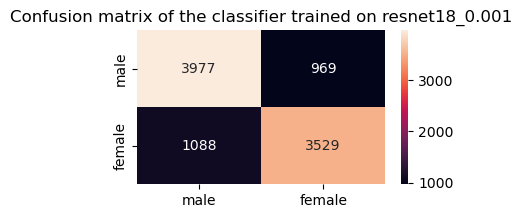

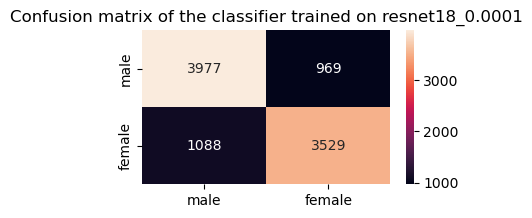

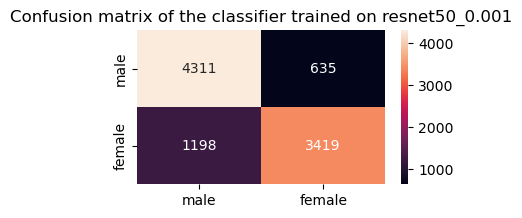

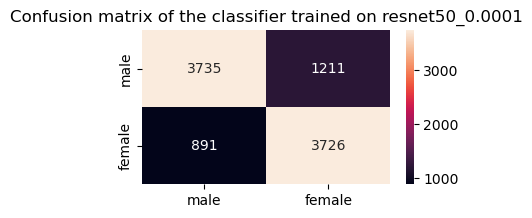

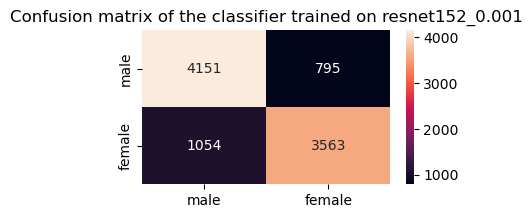

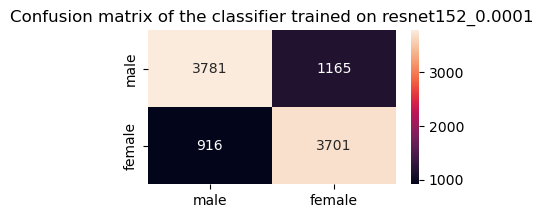

In [834]:
for conf_mat, model_name in zip(conf_mat_val_list, model_name_list):
    plot_confusion_matrix(conf_mat, (4, 2), f'{model_name}')

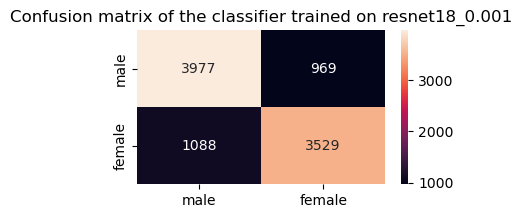

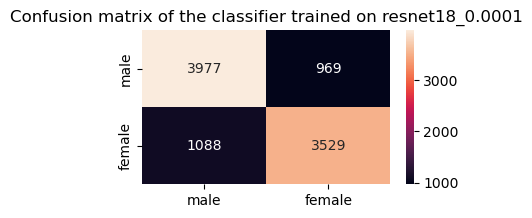

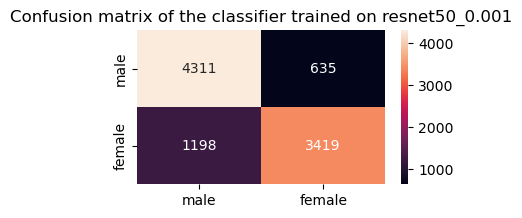

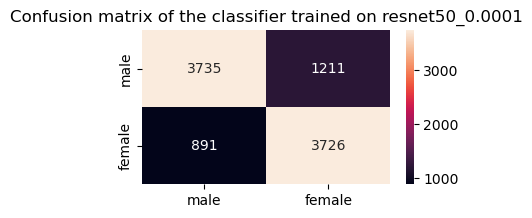

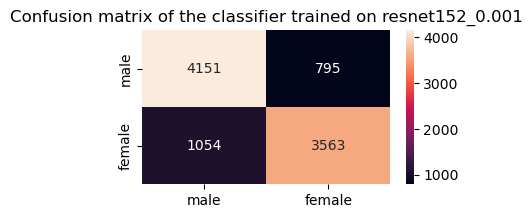

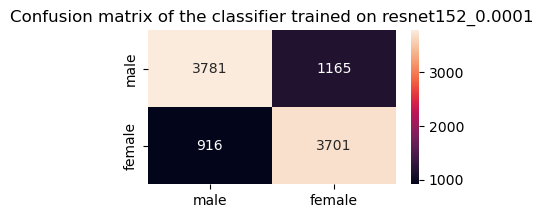

In [835]:
for conf_mat, model_name in zip(conf_mat_test_list, model_name_list):
    plot_confusion_matrix(conf_mat, (4, 2), f'{model_name}')

### Metrics for age predictions

For the age variable, mean absolute error, mean square error, root mean square error, and r2 scores were calculated for the all six models and both validation and test datasets. In the similar way, the lists containing true values and predictions were flattened from the sublists of batches. 

In [836]:
pred_val_age_flat_list = list(itertools.chain.from_iterable(predictions_val_age_list[0]))
y_true_val_age_flat_list = list(itertools.chain.from_iterable(y_true_val_age_list[0]))

In [837]:
pred_val_age_flat_list = []
y_true_val_age_flat_list = []
for lst1, lst2 in zip(predictions_val_age_list, y_true_val_age_list):
    pred_flat_list = list(itertools.chain.from_iterable(lst1))
    ytrue_flat_list = list(itertools.chain.from_iterable(lst2))
    
    pred_val_age_flat_list.append(pred_flat_list)
    y_true_val_age_flat_list.append(ytrue_flat_list)

In [838]:
pred_test_age_flat_list = []
y_true_test_age_flat_list = []
for lst1, lst2 in zip(predictions_test_age_list, y_true_test_age_list):
    pred_flat_list = list(itertools.chain.from_iterable(lst1))
    ytrue_flat_list = list(itertools.chain.from_iterable(lst2))
    
    pred_test_age_flat_list.append(pred_flat_list)
    y_true_test_age_flat_list.append(ytrue_flat_list)

In [857]:
for pred, ytrue, model_name in zip(pred_val_age_flat_list, y_true_val_age_flat_list, model_name_list):
 
    mae_val = mean_absolute_error(ytrue, pred)
    mse_val = mean_squared_error(ytrue, pred)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(ytrue, pred)
    print(f'{model_name}')
    print(f"Mean Absolute Error (MAE): {mae_val}")
    print(f"Mean Squared Error (MSE): {mse_val}")
    print(f"Root Mean Squared Error (RMSE): {rmse_val}")
    print(f"R-squared (R2): {r2_val}")
    print('')

resnet18_0.001
Mean Absolute Error (MAE): 12.257489086288196
Mean Squared Error (MSE): 240.59050483857598
Root Mean Squared Error (RMSE): 15.510980137907984
R-squared (R2): 0.40146188648624326

resnet18_0.0001
Mean Absolute Error (MAE): 12.257489086288196
Mean Squared Error (MSE): 240.59050483857598
Root Mean Squared Error (RMSE): 15.510980137907984
R-squared (R2): 0.40146188648624326

resnet50_0.001
Mean Absolute Error (MAE): 11.892338038257485
Mean Squared Error (MSE): 224.9586312393083
Root Mean Squared Error (RMSE): 14.998620977920213
R-squared (R2): 0.44035067031862585

resnet50_0.0001
Mean Absolute Error (MAE): 12.424452546088377
Mean Squared Error (MSE): 253.1322339846786
Root Mean Squared Error (RMSE): 15.910129917278445
R-squared (R2): 0.37026072620626727

resnet152_0.001
Mean Absolute Error (MAE): 11.925112503431064
Mean Squared Error (MSE): 223.6278493238589
Root Mean Squared Error (RMSE): 14.954191697442523
R-squared (R2): 0.4436613732813456

resnet152_0.0001
Mean Absolute 

In [858]:
for pred, ytrue, model_name in zip(pred_test_age_flat_list, y_true_test_age_flat_list, model_name_list):
 
    mae_test = mean_absolute_error(ytrue, pred)
    mse_test = mean_squared_error(ytrue, pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(ytrue, pred)
    print(f'{model_name}')
    print(f"Mean Absolute Error (MAE): {mae_test}")
    print(f"Mean Squared Error (MSE): {mse_test}")
    print(f"Root Mean Squared Error (RMSE): {rmse_test}")
    print(f"R-squared (R2): {r2_test}")
    print('')

resnet18_0.001
Mean Absolute Error (MAE): 12.257489086288196
Mean Squared Error (MSE): 240.59050483857598
Root Mean Squared Error (RMSE): 15.510980137907984
R-squared (R2): 0.40146188648624326

resnet18_0.0001
Mean Absolute Error (MAE): 12.257489086288196
Mean Squared Error (MSE): 240.59050483857598
Root Mean Squared Error (RMSE): 15.510980137907984
R-squared (R2): 0.40146188648624326

resnet50_0.001
Mean Absolute Error (MAE): 11.892338038257485
Mean Squared Error (MSE): 224.9586312393083
Root Mean Squared Error (RMSE): 14.998620977920213
R-squared (R2): 0.44035067031862585

resnet50_0.0001
Mean Absolute Error (MAE): 12.424452546088377
Mean Squared Error (MSE): 253.1322339846786
Root Mean Squared Error (RMSE): 15.910129917278445
R-squared (R2): 0.37026072620626727

resnet152_0.001
Mean Absolute Error (MAE): 11.925112503431064
Mean Squared Error (MSE): 223.6278493238589
Root Mean Squared Error (RMSE): 14.954191697442523
R-squared (R2): 0.4436613732813456

resnet152_0.0001
Mean Absolute 

It can be observed that the the models which were fine-tuned with the higher number of epoch present better scores both for gender and age variables. Also, it could be concluded that there are no significant differentes between performance scores of model predictions on validation and test datasets. 

As in the case of gender, variable the models resnet50_0.001 and resnet152_0.001 generate the best scores (the last one gives slighly better scores for MAE, MSE, RMSE and R2 than the first one, but the difference is insignificant).

### Analysis of the predicted images

Next, the analysis of well and wrongly predicted images is provided. for the analysis the resnet152_0.001 model that generated the best prediction scores is used. 

For the gender variable, the wrongly predicted images were presented (by randomly selecting 5 images).

#### Gender:

In [862]:
wrong_indices = [i for i, (true, pred) in enumerate(zip(y_true_val_gender_flat_list[4], 
                                                        pred_val_gender_flat_list[4])) if true != pred]

selected_indices = random.sample(wrong_indices, min(5, len(wrong_indices)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


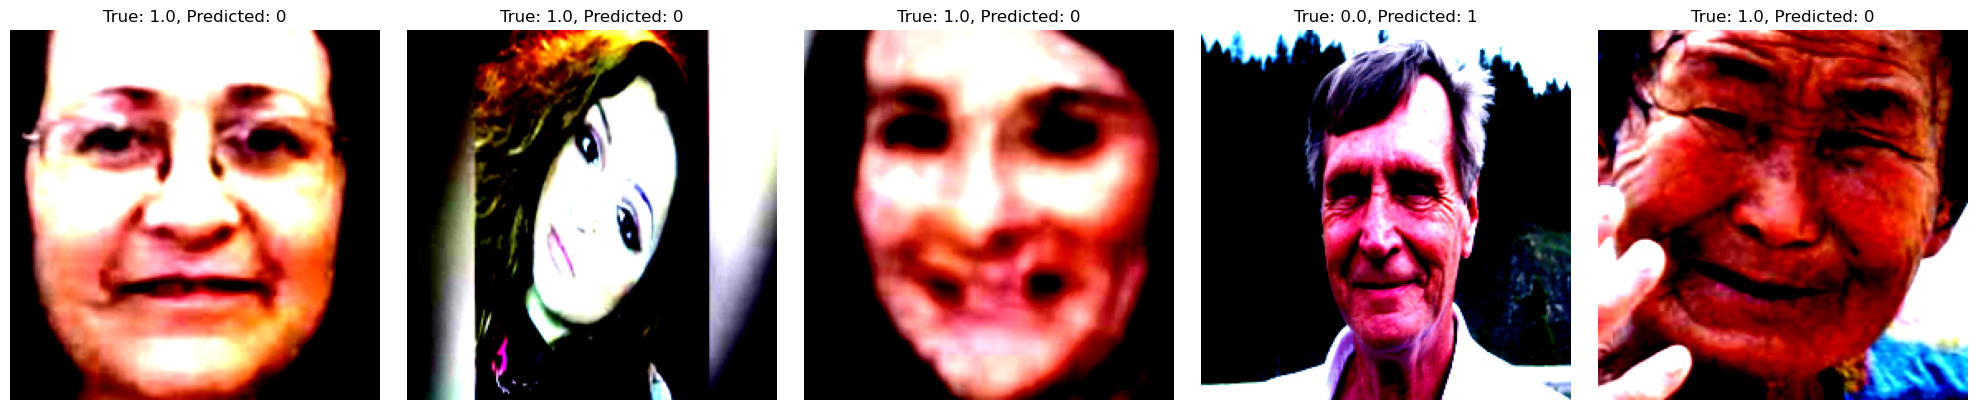

In [864]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, idx in enumerate(selected_indices):
    image, true_label, _ = val_dataset[idx]
    predicted_label = pred_val_gender_flat_list[4][idx]

    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(f"True: {true_label}, Predicted: {predicted_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show();

Also, the distribution of correctly predicted images was ploted with the bar plot (see bellow).

In [865]:
correct_predictions = [true == pred for true, pred in zip(y_true_val_gender_flat_list[4], 
                                                          pred_val_gender_flat_list[4])]


In [868]:
gender_df = pd.DataFrame({'Gender': y_true_val_gender_flat_list[4], 'CorrectPrediction': correct_predictions})
gender_df['Gender'] = gender_df['Gender'].map({0: 'Male', 1: 'Female'})
gender_group_percentages = gender_df.groupby('Gender')['CorrectPrediction'].mean() * 100


In [869]:
gender_group_percentages

Gender
Female    77.171323
Male      83.926405
Name: CorrectPrediction, dtype: float64

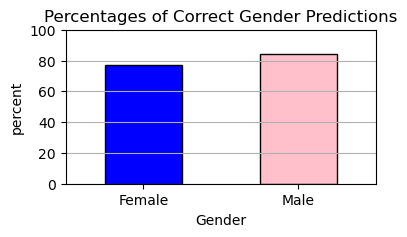

In [874]:

plt.figure(figsize=(4, 2))
gender_group_percentages.plot(kind='bar', color=['blue', 'pink'], edgecolor='black')
plt.title('Percentages of Correct Gender Predictions')
plt.xlabel('Gender')
plt.ylabel('percent')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

It can be observed that the percentage of men whose gender was correctly predicted (84 %) is higher than the percentage of women (74 %).

#### Age:

For the age variable, differences between real and predicted values were calculated and plotted. It can be seen that these differences are distributed in the form of a half of the bell shape, that is, smaller differences are more frequent while larger differences are less frequent. Still, it can be observed that there are images where prediction of the age was incorrect by 50 years and more.

In [871]:
age_differences = [abs(true - pred) for true, pred in zip(y_true_val_age_flat_list[4], pred_val_age_flat_list[4])]


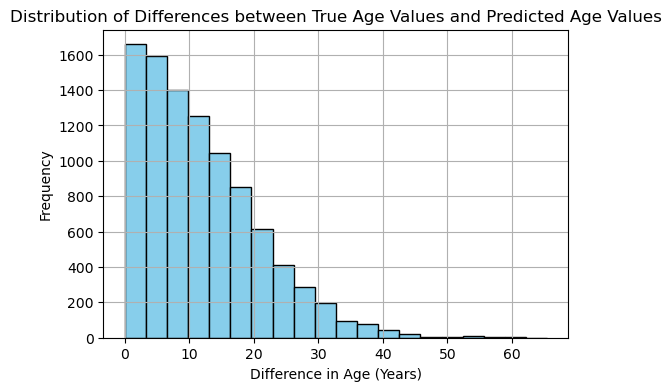

In [873]:
plt.figure(figsize=(6, 4))
plt.hist(age_differences, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences between True Age Values and Predicted Age Values')
plt.xlabel('Difference in Age (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [875]:
indices_largest_diff1 = np.argsort(age_differences)[-5:]
indices_largest_diff2 = np.argsort(age_differences)[:5]

The 5 images with the worst predictions are presented bellow.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


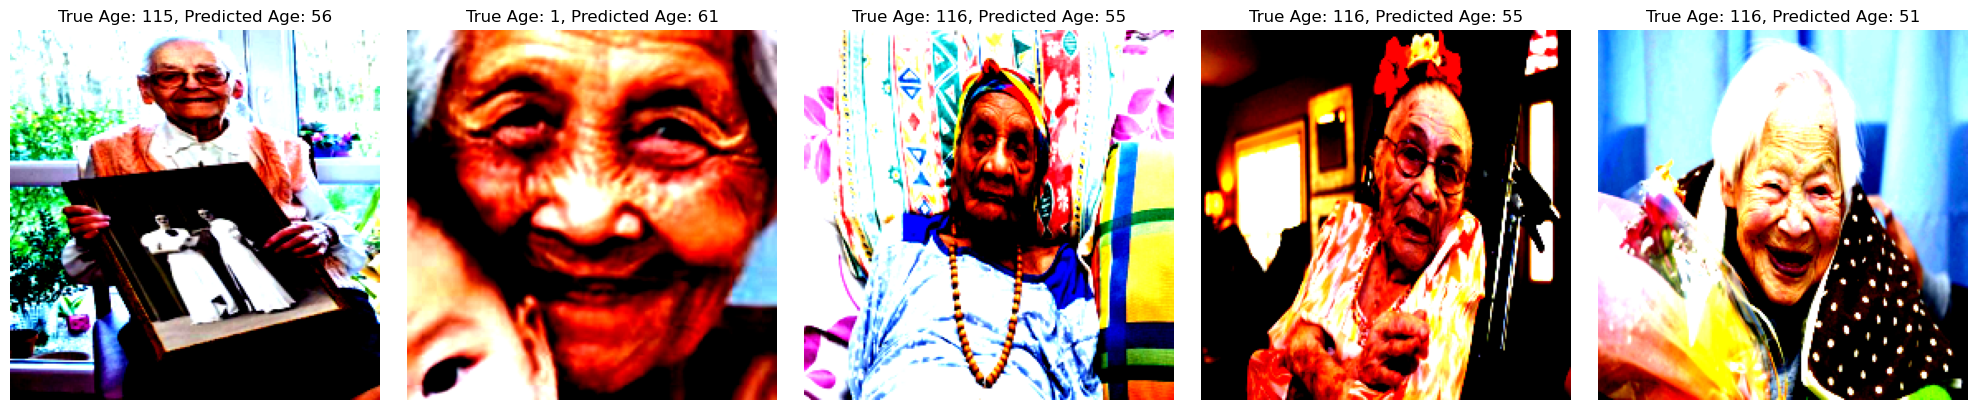

In [877]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(indices_largest_diff1):
    image, _, true_label = val_dataset[idx] 
    predicted_label = pred_val_age_flat_list[4][idx]

    true_label_rounded = round(true_label.item())
    predicted_label_rounded = round(predicted_label)

    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(f"True Age: {true_label_rounded}, Predicted Age: {predicted_label_rounded}")
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

It can be seen that the classifier mistakenly predicts age of persons who are 100 years old or older.

Here, the images with matching predictions are presented. It can be seen that these are images of middle age persons. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


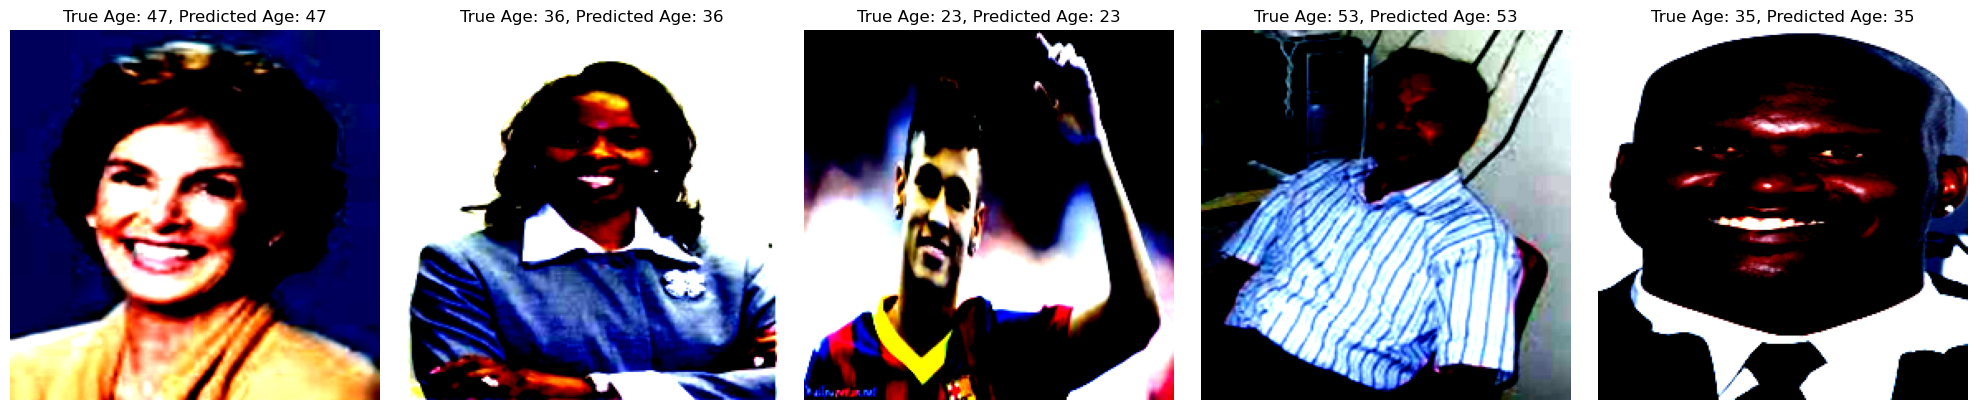

In [878]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(indices_largest_diff2):
    image, _, true_label = val_dataset[idx] 
    predicted_label = pred_val_age_flat_list[4][idx]

    true_label_rounded = round(true_label.item())
    predicted_label_rounded = round(predicted_label)

    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(f"True Age: {true_label_rounded}, Predicted Age: {predicted_label_rounded}")
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

In [879]:
age_intervals = [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 60), (61, 70), 
                 (71, 80), (81, 90), (91, 100), (101,120)]


Ages were categorized both in the predicted and real value lists. True value was assigned to those images which predicted and real values were in the same groups of age intervals. 

In [880]:
categorized_ages = [categorize_num_variable(age, age_intervals) for age in y_true_val_age_flat_list[4]]
categorized_ages_predicted = [categorize_num_variable(age, age_intervals) for age in pred_val_age_flat_list[4]]
correct_predictions = [true == round(pred) for true, pred in zip(categorized_ages, categorized_ages_predicted)]

The dataframe was constructed and percentages of correct predictions for each age group were calculated and plotted. 

In [882]:
age_df = pd.DataFrame({'true_age_group': categorized_ages, 
                   'predicted_age_group': categorized_ages_predicted, 
                   'true_values': y_true_val_age_flat_list[4],
                   'predicted_values': pred_val_age_flat_list[4],
                   'CorrectPrediction': correct_predictions})
age_group_percentages = age_df.groupby('true_age_group')['CorrectPrediction'].mean() * 100

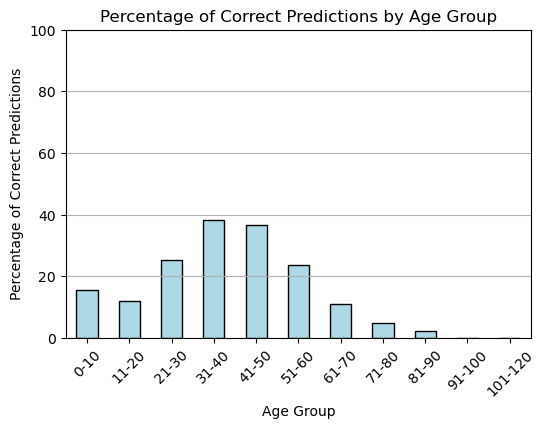

In [884]:

plt.figure(figsize=(6, 4))
age_group_percentages.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Percentage of Correct Predictions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Correct Predictions')
plt.xticks(ticks=range(len(age_intervals)), labels=[f'{interval[0]}-{interval[1]}' for interval in age_intervals], rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show();

It can be observed that the classifier provides better predictions for the age groups in the interval 31 - 40 and 41- 50 while almost all images in the the age groups in the interval 91-100 and 101-120 were classified incorectly. It is understandable because there were only few images of persons in these age groups. However, it is less understandable why the images in the age groups of children and teenagers (intervals 0-10 and 11-20) received lower rates of correct predictions because there age groups were even better represented in the dataset than mid-age people.

### Using the face classifier to predict gender and age of persons

Finally, the best performing classifier (resnet152_0.001) was chosen for the use of human face prediction on the new  images of persons. 

The functions were run on randomly selected images from the dataset and manually uploaded images of persons. The persons' images and their predicted labels are presented bellow. 

#### Predictions for images randomly selected from the dataset

The functions 'preprocess_random_images' and 'model_predict' are created. The function with the image path as an argument opens an image from the path, preprocesses it, loads the trained model from the checkpoint path, and provides prediction of the image class based on this model. The output of prediction is transformed into the tensor of probabilities for each class and then the class with the highest probability is selected. 

In [885]:
data_dir = "/Users/user/PycharmProjects/AdvancedDeepLearning/images_merged"

In [891]:
def model_predict(model, img: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Predicts the gender and age of a given image using a pre-trained model.

    Args:
        img (torch.Tensor): Input image to be predicted.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Predicted gender and age of the input image.
    """
    model.eval()
    with torch.no_grad():
        gender_logits, age_pred = model(img)
        gender_proba = F.sigmoid(gender_logits).squeeze()
        gender_hat = (gender_proba > 0.5).long()
        age_hat = age_pred.squeeze()
        return gender_hat, age_hat

In [890]:
def preprocess_random_images(data_dir: str, num_select: int) -> Union[Tuple[List[Image.Image], 
                                                    List[Tensor]], Tuple[Image.Image, Tensor]]:
    """
    Preprocesses a random selection of images from a given directory.

    Args:
        data_dir: The directory containing the images to be preprocessed.
        num_select: The number of images to be randomly selected.

    Returns:
        If num_select is greater than 1, a tuple containing a list of preprocessed images and a list of their encoded versions.
        If num_select is equal to 1, a tuple containing a single preprocessed image and its encoded version.
    """

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    all_files = os.listdir(data_dir)
    image_files = [file for file in all_files if file.endswith(('.jpg', '.png'))]
    selected_images = random.sample(image_files, num_select)

    if num_select > 1:
        image_list = []
        image_encoded_list = []
        for select_img in selected_images:
            selected_image_path = os.path.join(data_dir, select_img)
            image = Image.open(selected_image_path).convert('RGB')
            image_encoded = preprocess(image).unsqueeze(0)
            image_list.append(image)
            image_encoded_list.append(image_encoded)
        return image_list, image_encoded_list
    else:
        selected_image_path = os.path.join(data_dir, selected_images[0])
        image = Image.open(selected_image_path).convert('RGB')
        image_encoded = preprocess(image).unsqueeze(0)
        return image, image_encoded

In [892]:
gender_label_mapping = {0: 'male', 1: 'female'}

5 images are selected and preprocessed.

In [901]:
images, images_encoded = preprocess_random_images(data_dir, 5)

The best performing model is loaded. 

In [896]:
checkpoint_path = f"models/UTKFace_tuned_resnet152_0.001.ckpt"
model = UTKFaceResNet.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    batch_size=batch_size,
    num_classes_gender=num_classes_gender,
    num_classes_age=num_classes_age,
    weights_gender=weights_gender,
    weights_age=weights_age,
    model=resnet_name,
    lr=lr,
)
device = torch.device("cpu")
model.to(device)


Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


UTKFaceResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

The function model_predict() is run for each of the five images. 

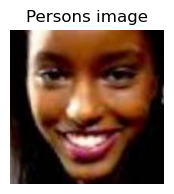

The gender of the person: female
The age of the person: 34


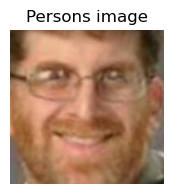

The gender of the person: male
The age of the person: 62


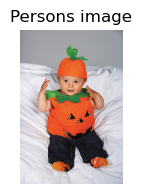

The gender of the person: female
The age of the person: 41


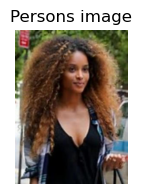

The gender of the person: female
The age of the person: 32


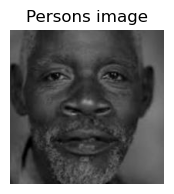

The gender of the person: male
The age of the person: 50


In [902]:
for image, image_encoded in zip(images, images_encoded):
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(image)
    plt.title("Persons image")
    plt.show();
    gender_hat, age_hat  = model_predict(model, image_encoded)
    gender_label = gender_label_mapping[gender_hat.item()]
    
    print(f'The gender of the person: {gender_label}')
    print(f'The age of the person: {round(age_hat.tolist())}')

It can be observed that 1, 2, and 4 images are classified correctly, while the prediction of the 3 image is completely mistaken and in the 5 image the man seems older than it is predicted.

#### Predictions for uploaded images: 

Also, the predictions of the model are checked with manually uploaded images (of myself and my family members). Some photos of persons images were made and saved into a separate folder. 

The images were resized to the size 800x600 in order to avoid image truncation errors (see bellow) with teh functions resize_img() and resize_image(). Resized images were saved to a new folder.

In [ ]:
input_dir = '/Users/user/PycharmProjects/AdvancedDeepLearning/faces_uploaded'
output_dir = '/Users/user/PycharmProjects/AdvancedDeepLearning/faces_resized'


In [659]:
def resize_img(input_path: str, output_path: str, new_width: int, new_height: int) -> (bool, str):
    """
    Resizes an image to the specified width and height and saves it to the specified output path.

    Args:
        input_path (str): The path to the input image.
        output_path (str): The path to save the resized image.
        new_width (int): The new width of the image.
        new_height (int): The new height of the image.

    Returns:
        (bool, str): A tuple containing a boolean indicating if the resizing was successful and a message.
    """
    try:
        with Image.open(input_path) as img:
            img = img.resize((new_width, new_height), Image.ANTIALIAS)
            img.save(output_path)
        return True, "Image resized successfully!"
    except Exception as e:
        return False, str(e)

In [660]:
def resize_image(input_path: str, output_path: str, new_width: int, new_height: int) -> None:
    """
    Resizes an image from the input path to the output path with the given new width and height.

    Args:
        input_path (str): Path to the input image.
        output_path (str): Path to save the resized image.
        new_width (int): New width of the resized image.
        new_height (int): New height of the resized image.

    Returns:
        None.
    """
    new_width = new_width 
    new_height = new_height
    images = [f for f in os.listdir(input_path) if f.lower().endswith('.jpg')]
    for image in images:
        input_image_path = os.path.join(input_path, image)
        output_image_path = os.path.join(output_path, image)
        img = Image.open(input_image_path)
        success, message = resize_img(input_image_path, output_image_path, new_width, new_height)
        if success:
            print(message)
        else:
            print("Error:", message)

In [912]:
resize_image(input_dir, output_dir, 800, 600)

Image resized successfully!
Image resized successfully!
Image resized successfully!
Image resized successfully!


The images and predictions of the model are presented bellow. 

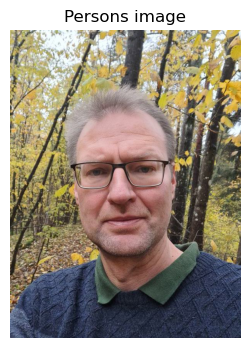

The gender of the person: male
The age of the person: 52


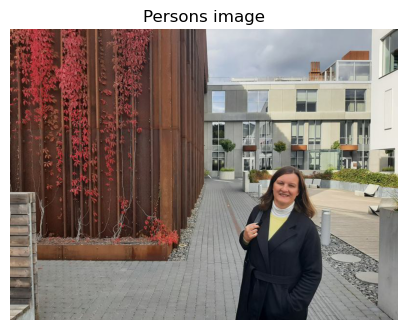

The gender of the person: male
The age of the person: 51


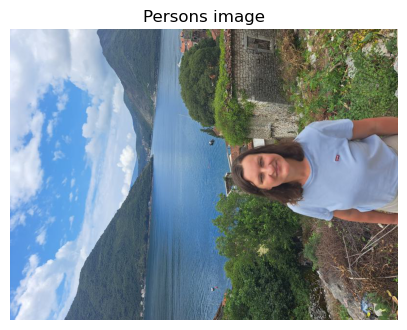

The gender of the person: female
The age of the person: 35


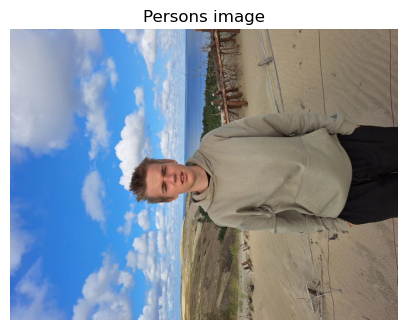

The gender of the person: female
The age of the person: 54


In [914]:
images = [f for f in os.listdir(output_dir) if f.lower().endswith('.jpg')]
for image in images:
    image_path = os.path.join(output_dir, image)
    example_image = Image.open(image_path)
    plt.figure(figsize=(5, 4))
    plt.axis('off')
    plt.imshow(example_image)
    plt.title("Persons image")
    plt.show();
    image_to_explain = preprocess(example_image).unsqueeze(0)
    gender_hat, age_hat  = model_predict(model, image_to_explain)
    gender_label = gender_label_mapping[gender_hat.item()]
    
    print(f'The gender of the person: {gender_label}')
    print(f'The age of the person: {round(age_hat.tolist())}')

In the images presented only my own image is classified more or less correctly (though the model made me a bit older). It can be concluded that the model presents better results if the the portrait image is presented. If a person is more distanced from the camera the classifier present incorrect predictions. (It is understandable because the classifier was trained on mainly portrait images).

### Explaining predictions with LIME

Next, the way to apply LIME interpretability analysis for image predictions is presented. The function 'model_explain_lime()' is created to present predictions in the form understandable by the LIME explaner.

In [662]:
explainer = lime_image.LimeImageExplainer()

In [663]:
def model_explain_lime(img_np_array: np.ndarray) -> np.ndarray:
    """
    Takes in an image represented as a numpy array and returns the predictions
    for gender and age made by the model.

    Parameters:
        img_np_array (np.ndarray): The image represented as a numpy array.

    Returns:
        np.ndarray: An array containing the predictions for gender and age.
    """
    img_tensor = torch.from_numpy(img_np_array.transpose(0, 3, 1, 2)).float()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean, std)
    img_tensor = normalize(img_tensor)
    img_tensor = img_tensor.to(device)

    model.eval()
    with torch.no_grad():
        gender_logits, age_pred = model(img_tensor)
        gender_proba = torch.sigmoid(gender_logits).squeeze(-1)
        age_hat = age_pred.squeeze(-1)

        predictions = np.hstack([gender_proba.cpu().numpy()[..., np.newaxis], 
                                 age_hat.cpu().numpy()[..., np.newaxis]])
        return predictions
     

A numpy array from a tensor of a randomly selected image is created and the LIME class method 'explain_instance()' is run on that image array.

In [664]:
image_np = np.array(images[3])

In [434]:
explanation = explainer.explain_instance(image_np, model_explain_lime, top_labels=5,
                                         hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

This lime object together with the image is plotted with the method 'get_image_and_mask()'. The plot presents the parts of the image which were mostly useful for the prediction. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


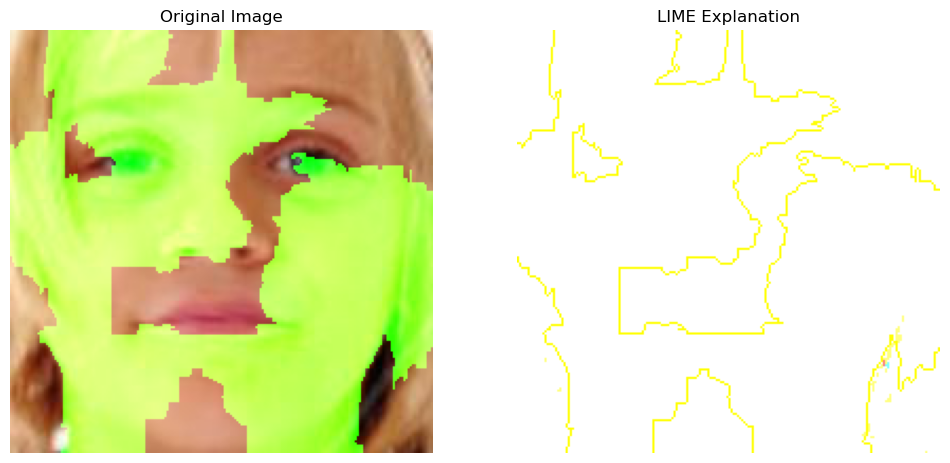

In [435]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, num_features=10, hide_rest=False)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(temp)
axes[0].set_title('Original Image')
axes[0].axis('off')

lime_img = mark_boundaries(temp / 2 + 0.5, mask)
axes[1].imshow(lime_img)
axes[1].set_title('LIME Explanation')
axes[1].axis('off')

plt.show()

In [678]:
def explain_with_heatmap(explanation, exp_class: int) -> None:
    """Generates a heatmap to explain the contribution of each feature to a specific class.

    Args:
        exp (Explanation): The explanation object containing the local explanations.
        exp_class (int): The class for which the heatmap is generated.

    Returns:
        None. The function plots and displays the heatmap.
    """
    dict_heatmap = dict(explanation.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

Also, the heatmap identifying the places of the image which contributed to the prediction the most as dark blue and the places which contributed the least as dark red. 

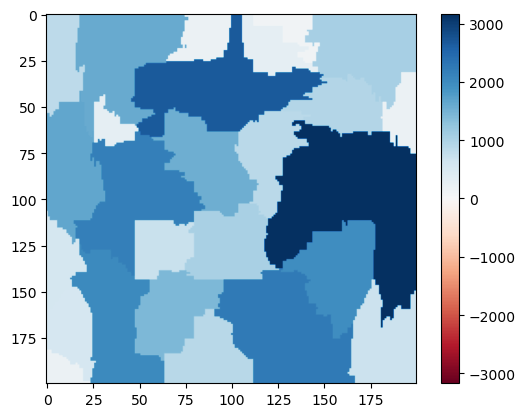

In [679]:
explain_with_heatmap(explanation, explanation.top_labels[0])

It can be observed that various parts of face are these that contribute to the predictions the most while the background of the image and other objects in the image not related to the human face contribute to the predictions the least. 

### Discussion of ethical issues

The classifier is trained to predict gender and age of persons from the images, however, the applicability of such a classifier in real life situations is limited due to several reasons:
- the classifier is biased to certain age groups (it less correcly predicts age of young and older persons);
-  biased models could lead to false identifications;
- biased models could lead to incorrect assumptions about demographics of certain population;
- even the better performance of the model is achieved, using the model for targeted advertising or job candidate screening could lead to discriminatory practices;
- Use of facial recognition raises privacy issues (users should consent to their data being used, and data should be securely stored).


## Conclusions

The project provides the exploratory analysis and training of pretrained image classification models for the purpose of multi-task classification of images of human faces - that is, to train classifiers able to predict gender and age of persons. 

The exploratory analysis revealed that:
- the dataset is imbalanced (persons of the white race are better represented in the dataset than persons of other races; older persons are underrepresented comparing to age groups of younger persons).
By examining the modeling results it can be observed that:
- the model which generated the best prediction scores for gender and age is resnet152 trained and fine-tuned with the learning rate 0.001 in 30 epochs;
- the male gender is slightly better predicted that female gender (84 % correct predictions for male and 77 % correct predictions for female gender);
- in general, gender is better predicted than age (the best performing model generated f1 score equal to 0.82 for male gender and 0.79 for female gender; while loss scores for age are quite high -  the mse loss equal to 223 for the best model).
- Age groups which were predicted the best were in the interval 30-40 and 40-50;
- the age for younger persons (less than 20 years old) is relatively badly predicted (as these age groups are well represented in the dataset, but got lower percentages of correct predictions);
- age groups of older persons (more than 80 years old) are under-represented and badly predicted;
- the classifier performs better if it receives portrait images rather than images when a person is in the distance from the camera;
- the applicability of the classifier in the real life situations is limited due to biases in predictions and other ethical issues (privacy, data security, etc.);

#### Limitations and suggestions for improvement:

##### Limitations:

1. Only the models of resnet group were used for multitask classification of gender and age though there are quite many other image classification models that could potentially be used such as VGGNet, Inception (GoogLeNet), DenseNet, EfficientNet, Xception, Transformer-based Models (e.g. Vision Transformers), etc.
2. It was planned to examine how correct predictions of gender and age are distributed in different race groups, however, it was not done due to the kernel crash which caused the loss of prediction data saved in lists (the models had to be run for predictions again that would have taken some time).

##### Suggestions for improvement:

1. to enrich the dataset with additional images of human faces in order ro mitigate the bias of the data.
2. to exploit other image classification models for training and fine-tuning and to compare them with the performance of the resnet models.
3. to examine how correct predictions of gender and age are distributed in different race groups.

## References

1. ChatGPT.OpenAI, https://chat.openai.com/
2. Zhang, Zhifei, Song, Yang, and Qi, Hairong. Age Progression/Regression by Conditional Adversarial Autoencoder, IEEE Conference on Computer Vision and Pattern Recognition (CVPR)}, 2017, 
https://doi.org/10.48550/arXiv.1702.08423.
3. UTKFace. Kaggle, https://www.kaggle.com/datasets/jangedoo/utkface-new